In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef

from scipy.stats import ttest_1samp
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from statsmodels.stats.multitest import multipletests
from matplotlib_venn import venn2
import math
from scipy.stats import ttest_ind

In [2]:
## bay across plates 
phase2_df=pd.read_csv('phase2_99_bay_std_across_slope(5.18).csv',low_memory=False)
cts_light = ['20h_HL', '20h_ML']
phase2_df['y2_slope_select'] = phase2_df.apply(
    lambda row: row['y2_slope'] if row['light_regime'] in cts_light else row['y2_slope_on'],
    axis=1
)
phase2_df = phase2_df[~phase2_df['plate'].astype(str).str.startswith('99')]


In [13]:
wt_df.shape

(468, 825)

In [7]:
wt_df['plate'].unique()

array(['31v3', '32v1', '30v1', '30v3', '32v3', '32v2', '31v2', '30v1_1',
       '30v2', '30v1_2', '31v1', '30v3_1', '30v3_2'], dtype=object)

In [3]:
import re

# Get WT and Mutant
wt_df = phase2_df[phase2_df['mutant_ID'] == 'WT'].copy()
mutant_df = phase2_df[phase2_df['mutant_ID'] != 'WT'].copy()

# Build list of pseudo-mutants
pseudo_mutants = []
dropped_index = []

for (plate, regime), group in wt_df.groupby(['plate', 'light_regime']):
    group = group.dropna(subset=['y2_slope_select'])

    if len(group) < 2:
        continue

    # Extract plate prefix (e.g., 30 from 30v1)
    match = re.match(r'(\d+)', str(plate))
    if not match:
        continue
    plate_prefix = match.group(1)

    # Randomly pick 2 rows
    sampled = group.sample(n=2, random_state=42).copy()

    # Assign fake mutant_IDs and mutated_genes
    sampled.iloc[0, sampled.columns.get_loc('mutant_ID')] = f'fake_{plate_prefix}_1'
    sampled.iloc[1, sampled.columns.get_loc('mutant_ID')] = f'fake_{plate_prefix}_2'
    sampled['mutated_genes'] = f'gene_{plate_prefix}'  # Same gene label for both

    pseudo_mutants.append(sampled)
    dropped_index.extend(sampled.index.tolist())

# Drop used WT rows
wt_df = wt_df.drop(index=dropped_index)

# Add fake mutants to mutant_df
pseudo_mutant_df = pd.concat(pseudo_mutants, ignore_index=True)
mutant_df = pd.concat([mutant_df, pseudo_mutant_df], ignore_index=True)


In [5]:
pseudo_mutant_df[['plate','mutated_genes']]

plate mutated_genes
0    30v1       gene_30
1    30v1       gene_30
2    30v1       gene_30
3    30v1       gene_30
4    30v1       gene_30
..    ...           ...
137  32v3       gene_32
138  32v3       gene_32
139  32v3       gene_32
140  32v3       gene_32
141  32v3       gene_32

[142 rows x 2 columns]

## paired t test(mutant)

In [37]:
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

paired_delta_results = []

group_keys = ['mutant_ID', 'mutated_genes', 'light_regime']
grouped = mutant_df.groupby(group_keys)

for (mutant_id, gene, regime), group in grouped:
    group = group[['plate', 'y2_slope_select']].dropna()
    if group.empty:
        continue

    deltas = []

    for _, row in group.iterrows():
        plate = row['plate']
        mutant_val = row['y2_slope_select']

        wt_plate_vals = wt_df[
            (wt_df['light_regime'] == regime) &
            (wt_df['plate'] == plate)
        ]['y2_slope_select'].dropna()

        if wt_plate_vals.empty:
            continue

        wt_mean = wt_plate_vals.mean()
        delta = mutant_val - wt_mean
        deltas.append(delta)

    if len(deltas) < 2:
        continue

    t_stat, p_val = ttest_1samp(deltas, popmean=0)

    paired_delta_results.append({
        'mutant_ID': mutant_id,
        'mutated_genes': gene,
        'light_regime': regime,
        'n_replicates': len(deltas),
        't_stat': t_stat,
        'p_value': p_val,
        'delta_mean': np.mean(deltas)
    })

# Create DataFrame
paired_delta_df = pd.DataFrame(paired_delta_results)

# Apply BH correction within each light regime
def apply_bh(group):
    _, adj_p, _, _ = multipletests(group['p_value'], method='fdr_bh')
    group['p_adj'] = adj_p
    return group

paired_delta_df = paired_delta_df.groupby('light_regime', group_keys=False).apply(apply_bh)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_13584/2688589157.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paired_delta_df = paired_delta_df.groupby('light_regime', group_keys=False).apply(apply_bh)


In [8]:
def plot_pvalue_histograms_per_regime(ttest_results_all, bins=30):
    """
    Plot histograms of raw p-values for each light regime in a specified order.
    """
    # Define your desired order
    regime_order = [
        '20h_ML', '20h_HL', '2h-2h',
        '10min-10min', '5min-5min', '1min-5min',
        '1min-1min', '30s-30s'
    ]
    
    n_regimes = len(regime_order)
    n_cols = 3
    n_rows = (n_regimes + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)
    axes = axes.flatten()

    for i, regime in enumerate(regime_order):
        ax = axes[i]
        subset = ttest_results_all[ttest_results_all['light_regime'] == regime]
        sns.histplot(subset['p_value'], bins=bins, kde=False, color='steelblue', ax=ax)
        ax.set_title(f'{regime}')
        ax.set_xlabel('Raw p-value')
        ax.set_ylabel('Count')
        ax.set_xlim(0, 1)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Histogram of Raw P-values by Light Regime', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


In [12]:
def plot_BH_pvalue_histograms_per_regime(ttest_results_all, bins=30):
    """
    Plot histograms of raw p-values for each light regime in a specified order.
    """
    # Define your desired order
    regime_order = [
        '20h_ML', '20h_HL', '2h-2h',
        '10min-10min', '5min-5min', '1min-5min',
        '1min-1min', '30s-30s'
    ]
    
    n_regimes = len(regime_order)
    n_cols = 3
    n_rows = (n_regimes + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)
    axes = axes.flatten()

    for i, regime in enumerate(regime_order):
        ax = axes[i]
        subset = ttest_results_all[ttest_results_all['light_regime'] == regime]
        sns.histplot(subset['p_adj'], bins=bins, kde=False, color='orange', ax=ax)
        ax.set_title(f'{regime}')
        ax.set_xlabel('adj p-value')
        ax.set_ylabel('Count')
        ax.set_xlim(0, 1)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Histogram of Adjusted P-values by Light Regime', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_50852/2950575371.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


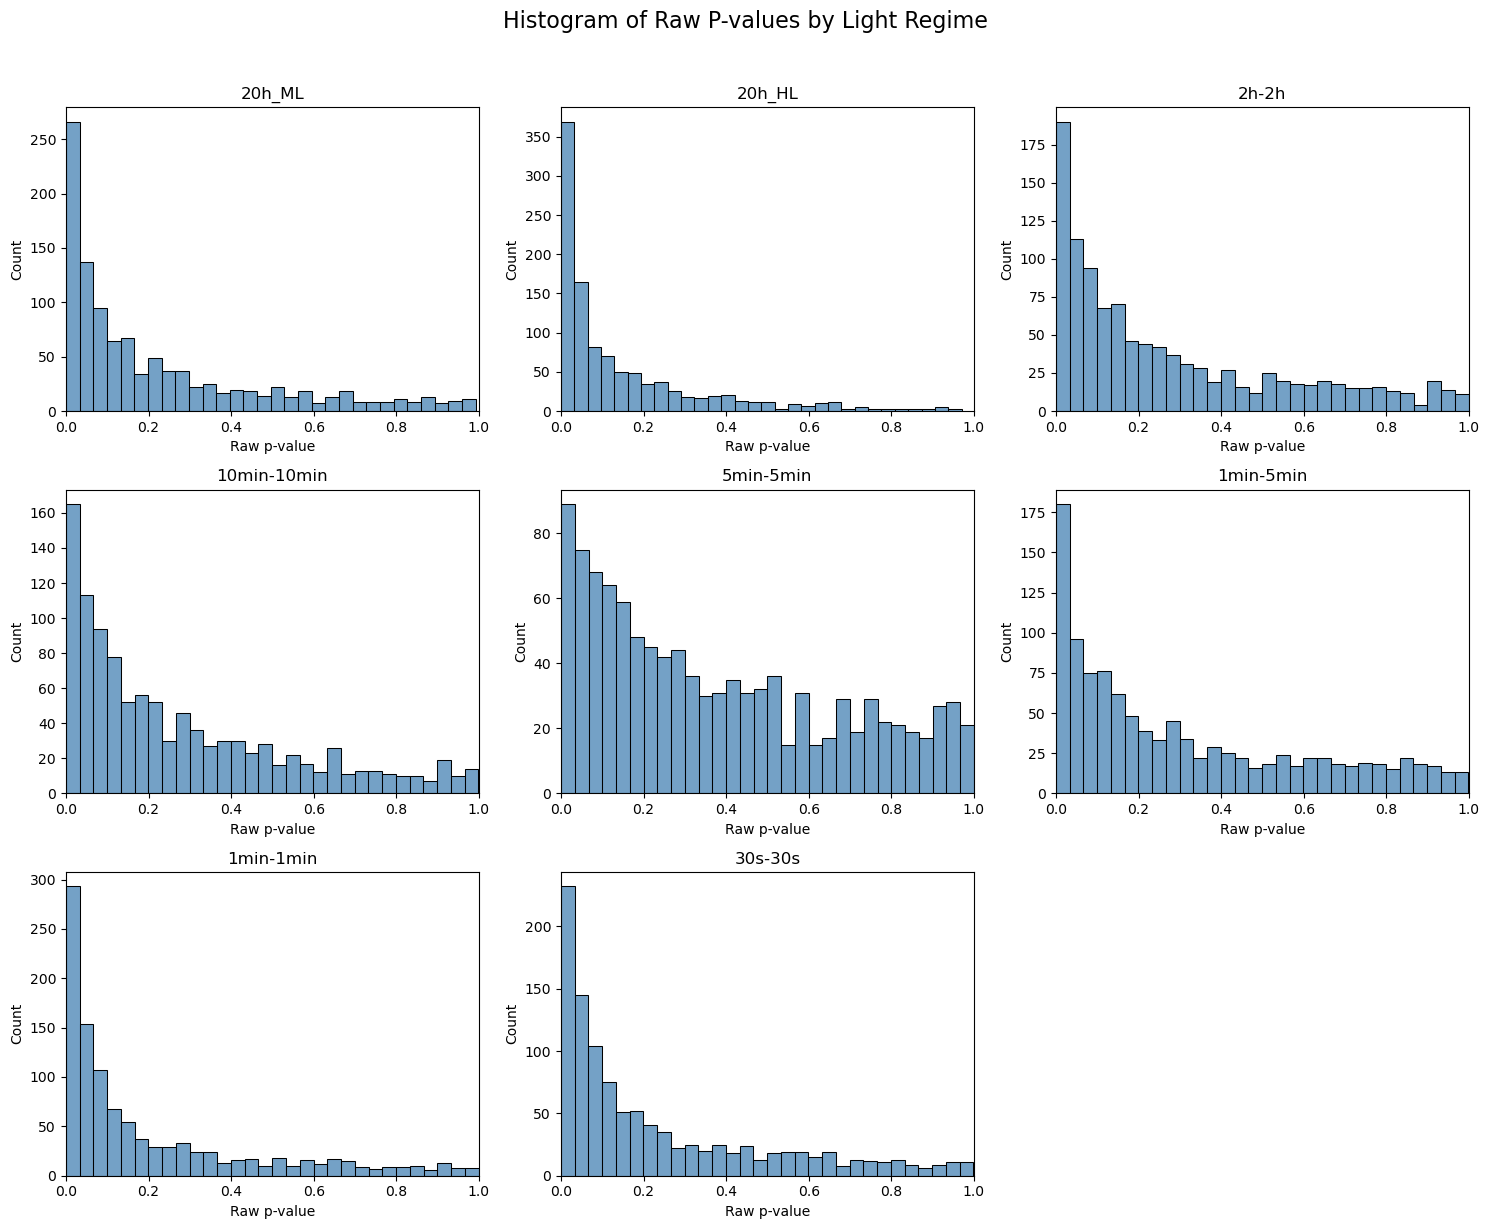

In [32]:
plot_pvalue_histograms_per_regime(paired_delta_df)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_50852/3642346334.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


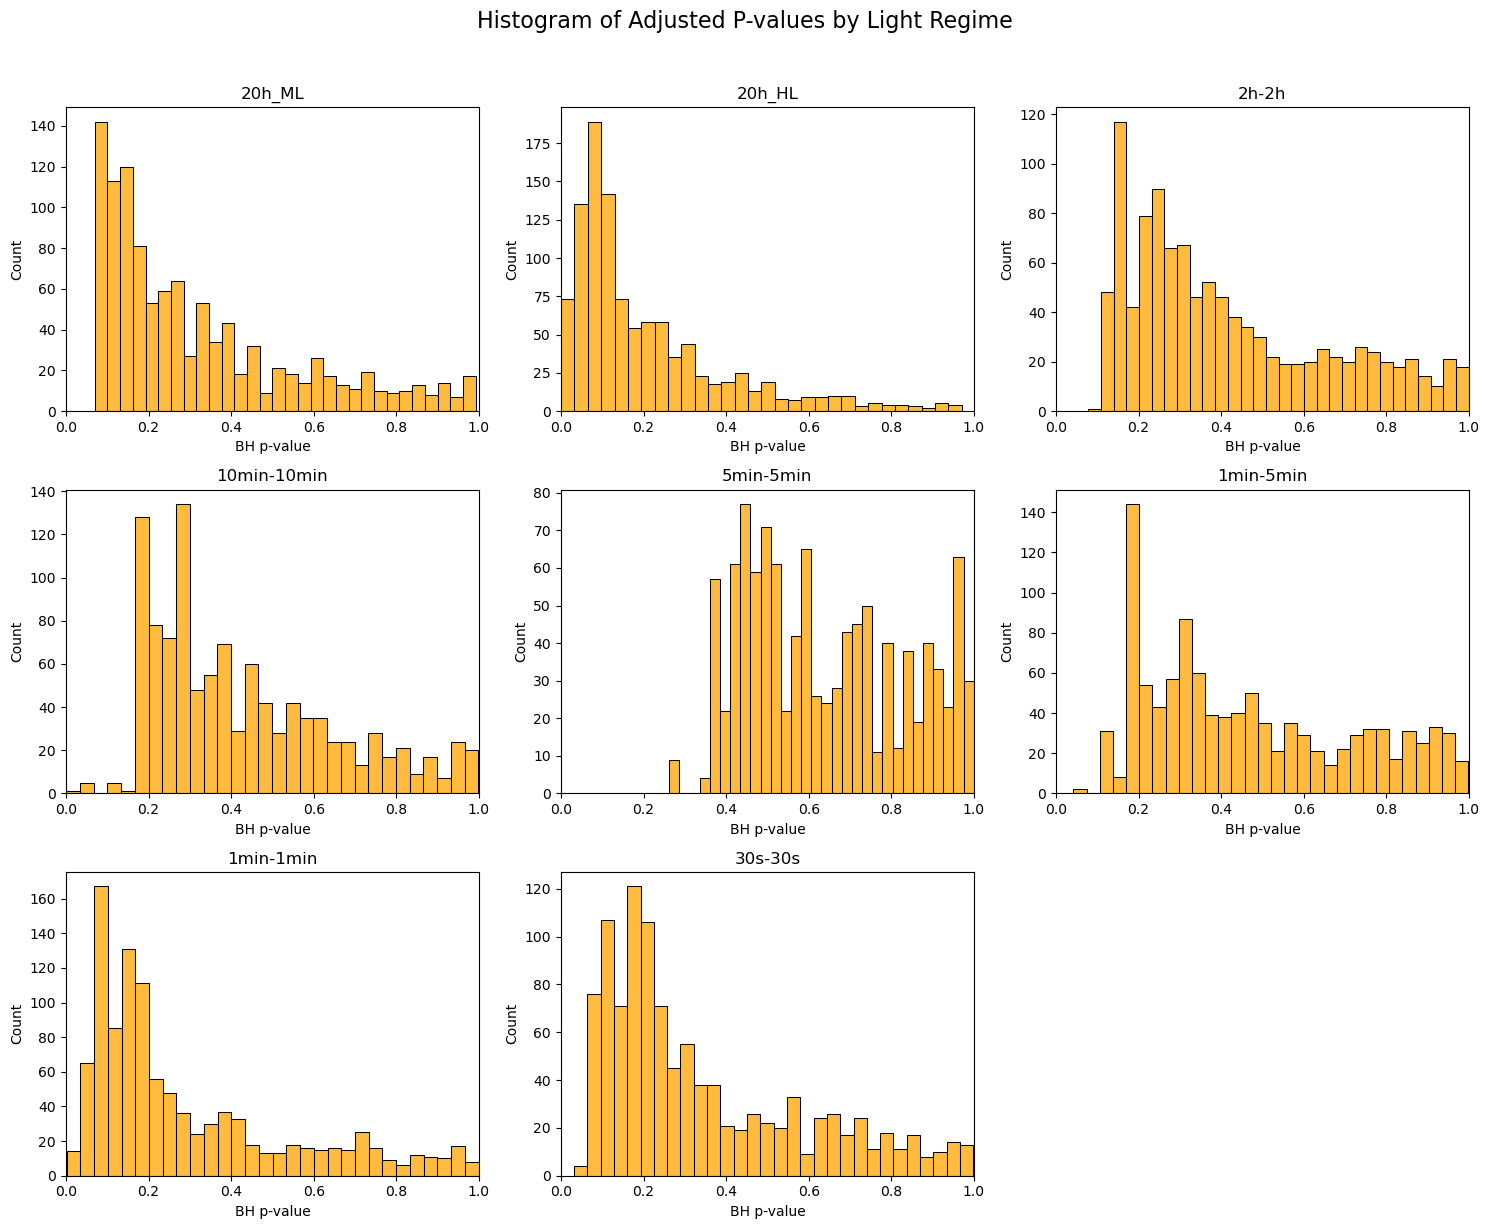

In [33]:
plot_BH_pvalue_histograms_per_regime(paired_delta_df)

In [34]:
def plot_volcano_per_light_regime1(ttest_results,
                                   p_thresh=1e-5,
                                   regimes_order=None,
                                   figsize=(14, 20),
                                   title_prefix='Volcano Plot'):
    
    # Compute effect size and -log10(p-adj)
    ttest_results['effect_size'] = ttest_results['delta_mean']
    ttest_results['neg_log10_p'] = -np.log10(ttest_results['p_adj'])

    # Define expected gene sets
    expected_ML =['Cre12.g531900']
    expected_2h =['Cre12.g531900']
    expected_10min =['Cre12.g531900']
    expected_5min =['Cre12.g531900']
    expected_1min_5min =['Cre12.g531900']
    expected_1min = {'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800', 'Cre13.g588150', 'Cre05.g235800','Cre15.g635800'}
    expected_30s = expected_1min
    expected_HL = {'Cre12.g531900','Cre02.g105350', 'Cre07.g323450'}

    # Combine all expected genes and assign unique colors
    all_expected_genes = sorted(set.union(expected_1min, expected_30s, expected_HL))
    expected_colors = sns.color_palette('Set1', n_colors=len(all_expected_genes))
    gene_to_color = dict(zip(all_expected_genes, expected_colors))

    # Determine plotting order
    if regimes_order is None:
        regimes = sorted(ttest_results['light_regime'].unique())
    else:
        regimes = regimes_order

    # Prepare subplot layout
    n = len(regimes)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, regime in enumerate(regimes):
        ax = axes[i]
        df = ttest_results[ttest_results['light_regime'] == regime].copy()

        # Get expected genes per regime
        expected_set = (
            expected_1min if regime == '1min-1min' else
            expected_30s if regime == '30s-30s' else
            expected_HL if regime == '20h_HL' else
            expected_ML if regime == '20h_ML' else
            expected_5min if regime=='5min-5min' else
            expected_10min if regime=='10min-10min' else
            expected_1min_5min if regime=='1min-5min'else
            expected_2h if regime=='2h-2h'else
            set()
        )

        df_expected = df[df['mutated_genes'].isin(expected_set)]
        df_others = df[~df['mutated_genes'].isin(expected_set)]

        # Plot background genes
        ax.scatter(df_others['effect_size'], df_others['neg_log10_p'],
                   color='gray', alpha=0.5, label='_nolegend_')

        # Plot expected genes
        for gene in expected_set:
            gene_data = df_expected[df_expected['mutated_genes'] == gene]
            ax.scatter(gene_data['effect_size'], gene_data['neg_log10_p'],
                       color=gene_to_color[gene], label=gene, s=40, alpha=0.9)

        y_thresh_main = -np.log10(p_thresh)
        ax.axhline(y_thresh_main, color='blue', linestyle='--', linewidth=1)
        ax.text(
            x=0.95 * ax.get_xlim()[1],
            y=y_thresh_main + 0.1,
            s=f'p = {p_thresh:.0e}',
            color='blue',
            ha='right',
            va='bottom',
            fontsize=10
        )
        
        
        # Threshold 3: p = 0.1
        y_thresh_01 = -np.log10(0.1)
        ax.axhline(y_thresh_01, color='green', linestyle='-.', linewidth=1)
        ax.text(
            x=0.95 * ax.get_xlim()[1],
            y=y_thresh_01 + 0.1,
            s='p = 0.1',
            color='green',
            ha='right',
            va='bottom',
            fontsize=10
        )

        # Set titles and labels
        ax.set_title(f'{title_prefix} — {regime}')
        ax.set_xlabel('Effect Size (Mutant - WT)')
        ax.set_ylabel('-log10(p-adjusted)')

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add unified legend for expected genes
    legend_patches = [Patch(color=gene_to_color[gene], label=gene) for gene in all_expected_genes]
    fig.legend(handles=legend_patches, title='Expected Genes', bbox_to_anchor=(1.02, 0.5), loc='center left')

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout for side legend
    plt.show()

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import math
from matplotlib import cm
def plot_volcano_per_light_regime1(ttest_results,
                                   p_thresh=1e-5,
                                   regimes_order=None,
                                   figsize=(14, 20),
                                   title_prefix='Volcano Plot'):

    # Compute effect size and -log10(p-adj)
    ttest_results['effect_size'] = ttest_results['delta_mean']
    ttest_results['neg_log10_p'] = -np.log10(ttest_results['p_adj'])

    # Define expected gene sets
    expected_ML = ['Cre12.g531900']
    expected_2h = ['Cre12.g531900']
    expected_10min = ['Cre12.g531900']
    expected_5min = ['Cre12.g531900']
    expected_1min_5min = ['Cre12.g531900']
    expected_1min = {'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800', 'Cre13.g588150', 'Cre05.g235800', 'Cre15.g635800'}
    expected_30s = expected_1min
    expected_HL = {'Cre12.g531900', 'Cre02.g105350', 'Cre07.g323450'}

    # Combine all expected genes and assign unique colors
    all_expected_genes = sorted(set.union(expected_1min, expected_30s, expected_HL))
    expected_colors = sns.color_palette('Set1', n_colors=len(all_expected_genes))
    gene_to_color = dict(zip(all_expected_genes, expected_colors))

    # Detect fake genes (e.g., gene_30, gene_31) and assign colors
    # fake_genes = sorted(g for g in ttest_results['mutated_genes'].unique() if g.startswith('gene_'))
    # fake_colors = sns.color_palette('Dark2', n_colors=len(fake_genes))
    # fake_gene_to_color = dict(zip(fake_genes, fake_colors))
    fake_genes = sorted(g for g in ttest_results['mutated_genes'].unique() if g.startswith('gene_'))
    coolwarm_colors = [cm.coolwarm(i / len(fake_genes)) for i in range(len(fake_genes))]
    fake_gene_to_color = dict(zip(fake_genes, coolwarm_colors))

    # Merge into one color mapping
    gene_to_color.update(fake_gene_to_color)
    all_expected_genes += fake_genes  # For legend

    # Determine plotting order
    if regimes_order is None:
        regimes = sorted(ttest_results['light_regime'].unique())
    else:
        regimes = regimes_order

    # Prepare subplot layout
    n = len(regimes)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, regime in enumerate(regimes):
        ax = axes[i]
        df = ttest_results[ttest_results['light_regime'] == regime].copy()

        # Determine which genes to highlight
        expected_set = (
            expected_1min if regime == '1min-1min' else
            expected_30s if regime == '30s-30s' else
            expected_HL if regime == '20h_HL' else
            expected_ML if regime == '20h_ML' else
            expected_5min if regime == '5min-5min' else
            expected_10min if regime == '10min-10min' else
            expected_1min_5min if regime == '1min-5min' else
            expected_2h if regime == '2h-2h' else
            set()
        )

        df_expected = df[df['mutated_genes'].isin(expected_set)]
        df_fake = df[df['mutated_genes'].isin(fake_genes)]
        df_others = df[
            ~df['mutated_genes'].isin(expected_set)
            & ~df['mutated_genes'].isin(fake_genes)
        ]

        # Plot background genes (non-expected, non-fake)
        ax.scatter(df_others['effect_size'], df_others['neg_log10_p'],
                   color='gray', alpha=0.5, label='_nolegend_')

        # Plot expected real genes
        for gene in expected_set:
            gene_data = df_expected[df_expected['mutated_genes'] == gene]
            if not gene_data.empty:
                ax.scatter(gene_data['effect_size'], gene_data['neg_log10_p'],
                           color=gene_to_color[gene], label=gene, s=40, alpha=0.9)

        # Plot fake genes
        for gene in fake_genes:
            gene_data = df_fake[df_fake['mutated_genes'] == gene]
            if not gene_data.empty:
                ax.scatter(gene_data['effect_size'], gene_data['neg_log10_p'],
                           color=gene_to_color[gene], label=gene, s=40, alpha=0.9)

        # Draw significance lines
        y_thresh_main = -np.log10(p_thresh)
        ax.axhline(y_thresh_main, color='blue', linestyle='--', linewidth=1)
        ax.text(
            x=0.95 * ax.get_xlim()[1],
            y=y_thresh_main + 0.1,
            s=f'p = {p_thresh:.0e}',
            color='blue',
            ha='right',
            va='bottom',
            fontsize=10
        )

        y_thresh_01 = -np.log10(0.1)
        ax.axhline(y_thresh_01, color='green', linestyle='-.', linewidth=1)
        ax.text(
            x=0.95 * ax.get_xlim()[1],
            y=y_thresh_01 + 0.1,
            s='p = 0.1',
            color='green',
            ha='right',
            va='bottom',
            fontsize=10
        )

        ax.set_title(f'{title_prefix} — {regime}')
        ax.set_xlabel('Effect Size (Mutant - WT)')
        ax.set_ylabel('-log10(p-adjusted)')

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add legend
    legend_patches = [Patch(color=gene_to_color[gene], label=gene) for gene in all_expected_genes]
    fig.legend(handles=legend_patches, title='Highlighted Genes', bbox_to_anchor=(1.02, 0.5), loc='center left')

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


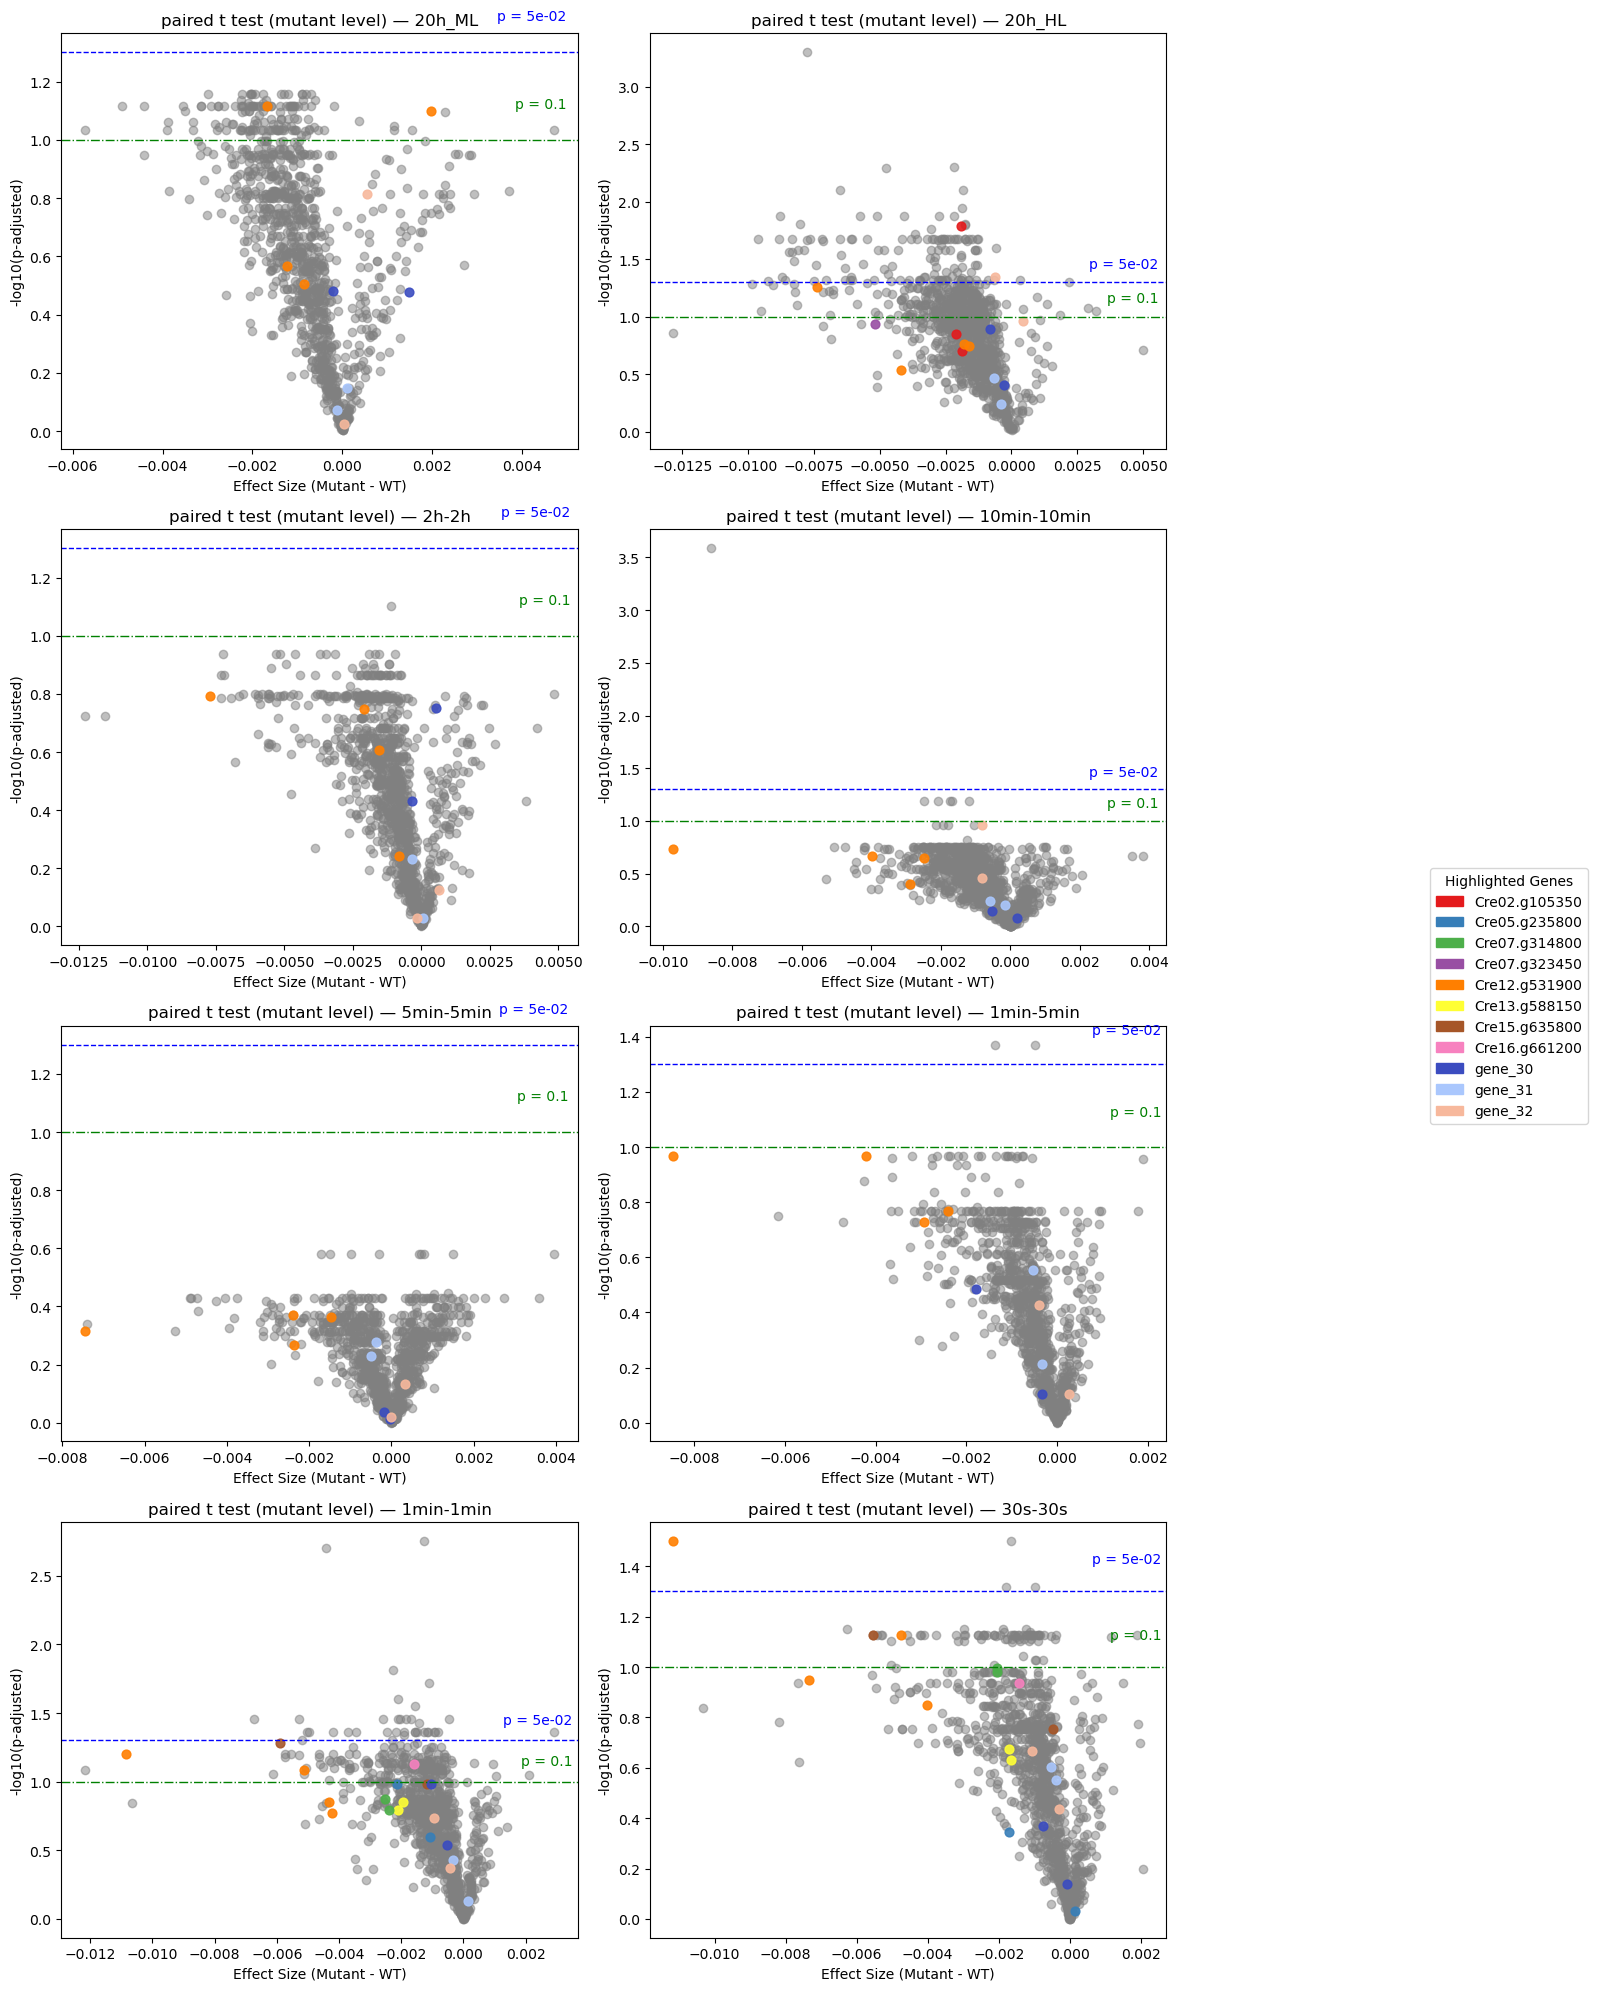

In [47]:
plot_volcano_per_light_regime1(
    paired_delta_df,
    p_thresh=0.05,
    regimes_order=['20h_ML', '20h_HL', '2h-2h', '10min-10min', '5min-5min', '1min-5min', '1min-1min', '30s-30s'],
    title_prefix='paired t test (mutant level)'
)

In [21]:
expected_1min = {'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800',
                     'Cre13.g588150', 'Cre05.g235800', 'Cre15.g635800'}
expected_30s = {'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800',
                     'Cre13.g588150', 'Cre05.g235800', 'Cre15.g635800'}
expected_HL       = {'Cre02.g105350','Cre07.g323450'}

# map expected sets to light regimes (add more keys if you have more regimes)
EXPECTED_BY_REGIME = {
    "1min-1min": expected_1min,
    "30s-30s": expected_30s,
    "20h_HL":   expected_HL
}

def compute_emp_fdr_table(df_shrunk):
    def compute_emp_fdr(sub_df, alpha):
        fake_mask = sub_df['mutated_genes'].str.startswith('gene_')
        sig_mask  = sub_df['p_adj'] <= alpha
        fp = int((sig_mask & fake_mask).sum())
        tp = int((sig_mask & ~fake_mask).sum())
        fdr = fp / (fp + tp) if (fp + tp) > 0 else 0.0
        return tp, fp, fdr

    results = []
    for light_regime, sub_df in df_shrunk.groupby('light_regime'):
        # Core FDR stats
        tp_05, fp_05, fdr_05 = compute_emp_fdr(sub_df, 0.05)
        tp_10, fp_10, fdr_10 = compute_emp_fdr(sub_df, 0.10)

        # Expected gene set for this regime
        expected = set(EXPECTED_BY_REGIME.get(light_regime, set()))

        # Count how many expected genes are detected (unique, not rows)
        def count_detected_expected_genes(alpha):
            sig_rows = sub_df[sub_df['p_adj'] <= alpha]
            detected_genes = set()
            for genes_str in sig_rows['mutated_genes']:
                detected_genes.update(genes_str.split(','))
            return len(expected & detected_genes)  # intersection with expected set

        detected_expected_05 = count_detected_expected_genes(0.05)
        detected_expected_10 = count_detected_expected_genes(0.10)
        
        def count_rows_with_expected(alpha):
            sig_rows = sub_df[sub_df['p_adj'] <= alpha]
            return int(sig_rows['mutated_genes'].apply(
                lambda genes: genes in expected  # exact match in expected set
            ).sum())
        

        results.append({
            'light_regime': light_regime,
            'TP_0.05': tp_05, 'FP_0.05': fp_05, 'EmpFDR_0.05': fdr_05,
            'mutant_0.05': count_rows_with_expected(0.05),
            'gene_0.05': detected_expected_05,
            'TP_0.1':  tp_10, 'FP_0.1':  fp_10, 'EmpFDR_0.1':  fdr_10,
            'mutant_0.1': count_rows_with_expected(0.10),
            'gene_0.1':  detected_expected_10,
        })

    df_result = pd.DataFrame(results)

    # Custom sort order
    custom_order = ["20h_ML", "20h_HL", "2h-2h", "10min-10min","5min-5min", "1min-5min", "1min-1min","30s-30s"]
    df_result['order'] = df_result['light_regime'].map({v: i for i, v in enumerate(custom_order)})
    df_result = df_result.sort_values('order').drop(columns='order').reset_index(drop=True)

    return df_result

In [47]:
emp_fdr_df1 = compute_emp_fdr_table(paired_delta_df)
emp_fdr_df1

light_regime  TP_0.05  FP_0.05  EmpFDR_0.05  mutant_0.05  gene_0.05  TP_0.1  \
0       20h_ML        0        0     0.000000            0          0     142   
1       20h_HL      129        1     0.007692            1          1     412   
2        2h-2h        0        0     0.000000            0          0       1   
3  10min-10min        1        0     0.000000            0          0       6   
4    5min-5min        0        0     0.000000            0          0       0   
5    1min-5min        2        0     0.000000            0          0       2   
6    1min-1min       34        0     0.000000            0          0     226   
7      30s-30s        4        0     0.000000            1          1      82   

   FP_0.1  EmpFDR_0.1  mutant_0.1  gene_0.1  
0       0    0.000000           0         0  
1       1    0.002421           1         1  
2       0    0.000000           0         0  
3       0    0.000000           0         0  
4       0    0.000000           0         0  
5       0    0.000000           0         0  
6       0    0.000000           4         3  
7       0    0.000000           3         2

## shrink var: piared t test (mutant)

In [6]:
paired_delta_results = []

group_keys = ['mutant_ID', 'mutated_genes', 'light_regime']
grouped = mutant_df.groupby(group_keys)

for (mutant_id, gene, regime), group in grouped:
    group = group[['plate', 'y2_slope_select']].dropna()
    if group.empty:
        continue

    deltas = []
    for _, row in group.iterrows():
        plate = row['plate']
        mutant_val = row['y2_slope_select']

        wt_plate_vals = wt_df[
            (wt_df['light_regime'] == regime) &
            (wt_df['plate'] == plate)
        ]['y2_slope_select'].dropna()

        if wt_plate_vals.empty:
            continue

        delta = mutant_val - wt_plate_vals.mean()
        deltas.append(delta)

    if len(deltas) < 2:
        continue

    deltas = np.array(deltas)
    delta_mean = deltas.mean()
    se_hat = deltas.std(ddof=1) / np.sqrt(len(deltas))  # standard error of the mean

    paired_delta_results.append({
        'mutant_ID': mutant_id,
        'mutated_genes': gene,
        'light_regime': regime,
        'n_replicates': len(deltas),
        'delta_mean': delta_mean,
        'se_hat': se_hat
    })

# Save for R use
paired_delta_df = pd.DataFrame(paired_delta_results)

In [7]:
paired_delta_df

mutant_ID  mutated_genes light_regime  n_replicates  delta_mean  \
0     LMJ.RY0402.038618  Cre17.g708800  10min-10min             2   -0.000898   
1     LMJ.RY0402.038618  Cre17.g708800    1min-1min             3   -0.001120   
2     LMJ.RY0402.038618  Cre17.g708800    1min-5min             3   -0.000113   
3     LMJ.RY0402.038618  Cre17.g708800       20h_HL             2   -0.001619   
4     LMJ.RY0402.038618  Cre17.g708800       20h_ML             3   -0.000793   
...                 ...            ...          ...           ...         ...   
8577          fake_32_2        gene_32       20h_HL             3   -0.000607   
8578          fake_32_2        gene_32       20h_ML             3    0.000538   
8579          fake_32_2        gene_32        2h-2h             3   -0.000155   
8580          fake_32_2        gene_32      30s-30s             3   -0.001071   
8581          fake_32_2        gene_32    5min-5min             3    0.000323   

        se_hat  
0     0.000133  
1     0.000089  
2     0.000188  
3     0.000489  
4     0.000578  
...        ...  
8577  0.000039  
8578  0.000123  
8579  0.001087  
8580  0.000350  
8581  0.000407  

[8582 rows x 6 columns]

In [9]:
paired_delta_df.to_csv("/Users/ruisi/Desktop/gene network/code 5.18 /phase2_shrink_var/paired_delta_for_vash_fake1.csv", index=False)

In [19]:
df_shrunk 

mutant_ID                                mutated_genes  \
0     LMJ.RY0402.038618                                Cre17.g708800   
1     LMJ.RY0402.038871                                Cre07.g322350   
2     LMJ.RY0402.039259                                Cre01.g023050   
3     LMJ.RY0402.040675  Cre01.g025400,Cre01.g025450 & Cre01.g025500   
4     LMJ.RY0402.040760                                Cre17.g697050   
...                 ...                                          ...   
8575  LMJ.RY0402.192722                                Cre13.g592100   
8576  LMJ.RY0402.201666                                Cre06.g278194   
8577  LMJ.RY0402.210603                                Cre02.g087450   
8578  LMJ.RY0402.218109                                Cre13.g592100   
8579  LMJ.RY0402.252961                  Cre02.g105150,Cre16.g688638   

     light_regime  n_replicates    delta_mean    se_hat   p_value  \
0     10min-10min             2 -8.982316e-04  0.000133  0.057325   
1     10min-10min             2 -2.049336e-03  0.000764  0.030129   
2     10min-10min             2 -2.890928e-04  0.000700  0.601279   
3     10min-10min             2 -7.495686e-04  0.000622  0.202110   
4     10min-10min             2 -1.252002e-03  0.000772  0.099597   
...           ...           ...           ...       ...       ...   
8575    5min-5min             6 -1.452593e-07  0.000296  0.999640   
8576    5min-5min             6  3.746013e-05  0.000374  0.908667   
8577    5min-5min             6 -3.037222e-04  0.000194  0.339230   
8578    5min-5min             6 -3.025300e-04  0.000247  0.344485   
8579    5min-5min             6 -2.117588e-04  0.000419  0.521334   

      se_hat_shrunk     p_adj  
0          0.000299  0.130777  
1          0.000527  0.091426  
2          0.000497  0.683619  
3          0.000461  0.309228  
4          0.000531  0.187797  
...             ...       ...  
8575       0.000321  0.999640  
8576       0.000326  0.963860  
8577       0.000316  0.626001  
8578       0.000318  0.629555  
8579       0.000329  0.759520  

[8580 rows x 9 columns]

In [18]:
df_shrunk = pd.read_csv("/Users/ruisi/Desktop/gene network/code 5.18 /phase2_shrink_var/mutant_paired_delta_with_shrunk_fake_se3.csv")


# Apply BH correction within each light_regime
def apply_bh(group):
    _, adj_p, _, _ = multipletests(group['p_value'], method='fdr_bh')
    group['p_adj'] = adj_p
    return group

df_shrunk = df_shrunk.groupby('light_regime', group_keys=False).apply(apply_bh)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_9286/2092921474.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shrunk = df_shrunk.groupby('light_regime', group_keys=False).apply(apply_bh)


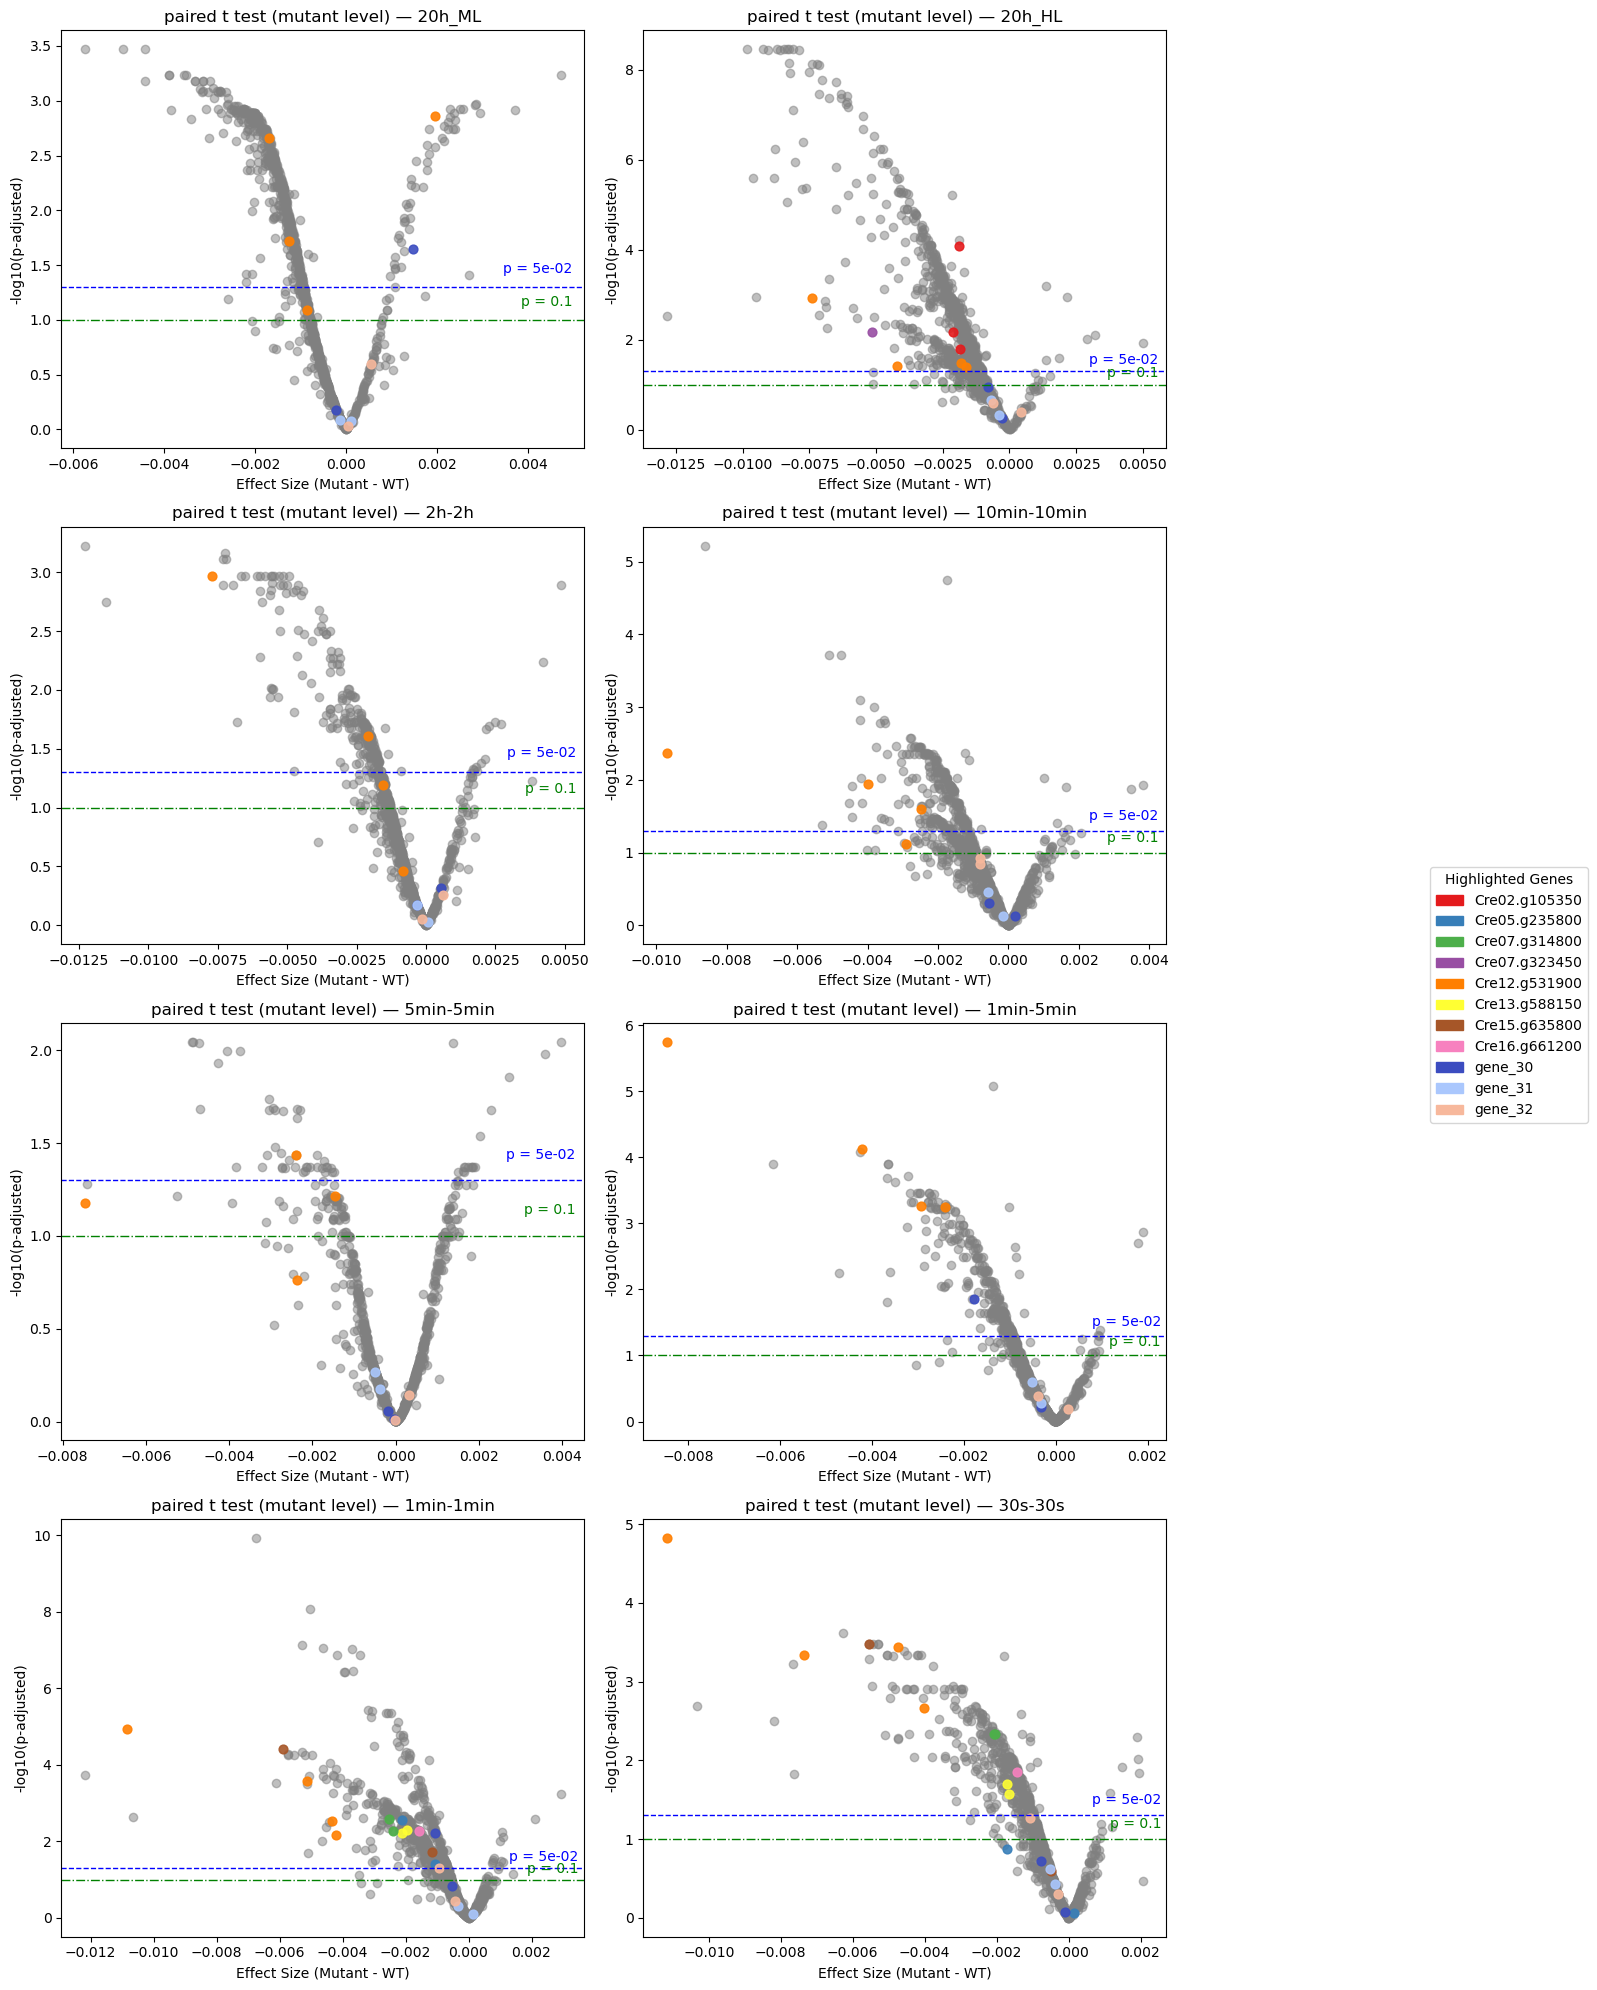

In [14]:
plot_volcano_per_light_regime1(
    df_shrunk,
    p_thresh=0.05,
    regimes_order=['20h_ML', '20h_HL', '2h-2h', '10min-10min', '5min-5min', '1min-5min', '1min-1min', '30s-30s'],
    title_prefix='paired t test (mutant level)'
)

In [23]:
df_shrunk

mutant_ID                                mutated_genes  \
0     LMJ.RY0402.038618                                Cre17.g708800   
1     LMJ.RY0402.038871                                Cre07.g322350   
2     LMJ.RY0402.039259                                Cre01.g023050   
3     LMJ.RY0402.040675  Cre01.g025400,Cre01.g025450 & Cre01.g025500   
4     LMJ.RY0402.040760                                Cre17.g697050   
...                 ...                                          ...   
8575  LMJ.RY0402.192722                                Cre13.g592100   
8576  LMJ.RY0402.201666                                Cre06.g278194   
8577  LMJ.RY0402.210603                                Cre02.g087450   
8578  LMJ.RY0402.218109                                Cre13.g592100   
8579  LMJ.RY0402.252961                  Cre02.g105150,Cre16.g688638   

     light_regime  n_replicates    delta_mean    se_hat   p_value  \
0     10min-10min             2 -8.982316e-04  0.000133  0.057325   
1     10min-10min             2 -2.049336e-03  0.000764  0.030129   
2     10min-10min             2 -2.890928e-04  0.000700  0.601279   
3     10min-10min             2 -7.495686e-04  0.000622  0.202110   
4     10min-10min             2 -1.252002e-03  0.000772  0.099597   
...           ...           ...           ...       ...       ...   
8575    5min-5min             6 -1.452593e-07  0.000296  0.999640   
8576    5min-5min             6  3.746013e-05  0.000374  0.908667   
8577    5min-5min             6 -3.037222e-04  0.000194  0.339230   
8578    5min-5min             6 -3.025300e-04  0.000247  0.344485   
8579    5min-5min             6 -2.117588e-04  0.000419  0.521334   

      se_hat_shrunk     p_adj   effect_size  neg_log10_p  
0          0.000299  0.130777 -8.982316e-04     0.883468  
1          0.000527  0.091426 -2.049336e-03     1.038932  
2          0.000497  0.683619 -2.890928e-04     0.165186  
3          0.000461  0.309228 -7.495686e-04     0.509721  
4          0.000531  0.187797 -1.252002e-03     0.726311  
...             ...       ...           ...          ...  
8575       0.000321  0.999640 -1.452593e-07     0.000157  
8576       0.000326  0.963860  3.746013e-05     0.015986  
8577       0.000316  0.626001 -3.037222e-04     0.203425  
8578       0.000318  0.629555 -3.025300e-04     0.200966  
8579       0.000329  0.759520 -2.117588e-04     0.119461  

[8580 rows x 11 columns]

In [48]:
emp_fdr_df2 = compute_emp_fdr_table(df_shrunk)
emp_fdr_df2

light_regime  TP_0.05  FP_0.05  EmpFDR_0.05  mutant_0.05  gene_0.05  TP_0.1  \
0       20h_ML      505        1     0.001976            0          0     596   
1       20h_HL      644        0     0.000000            4          2     772   
2        2h-2h      238        0     0.000000            0          0     374   
3  10min-10min      250        0     0.000000            0          0     392   
4    5min-5min       58        0     0.000000            0          0     140   
5    1min-5min      254        1     0.003922            0          0     344   
6    1min-1min      515        2     0.003868           13          6     610   
7      30s-30s      365        0     0.000000           10          5     480   

   FP_0.1  EmpFDR_0.1  mutant_0.1  gene_0.1  
0       1    0.001675           0         0  
1       0    0.000000           4         2  
2       0    0.000000           0         0  
3       0    0.000000           0         0  
4       0    0.000000           0         0  
5       1    0.002899           0         0  
6       2    0.003268          13         6  
7       1    0.002079          10         5

## shrink var: piared t test (mutant): fit a common prior

In [4]:
paired_delta_results = []

group_keys = ['mutant_ID', 'mutated_genes', 'light_regime']
grouped = mutant_df.groupby(group_keys)

for (mutant_id, gene, regime), group in grouped:
    group = group[['plate', 'y2_slope_select']].dropna()
    if group.empty:
        continue

    deltas = []
    for _, row in group.iterrows():
        plate = row['plate']
        mutant_val = row['y2_slope_select']

        wt_plate_vals = wt_df[
            (wt_df['light_regime'] == regime) &
            (wt_df['plate'] == plate)
        ]['y2_slope_select'].dropna()

        if wt_plate_vals.empty:
            continue

        delta = mutant_val - wt_plate_vals.mean()
        deltas.append(delta)

    if len(deltas) < 2:
        continue

    deltas = np.array(deltas)
    delta_mean = deltas.mean()
    se_hat = deltas.std(ddof=1) / np.sqrt(len(deltas))  # standard error of the mean

    paired_delta_results.append({
        'mutant_ID': mutant_id,
        'mutated_genes': gene,
        'light_regime': regime,
        'n_replicates': len(deltas),
        'delta_mean': delta_mean,
        'se_hat': se_hat
    })

# Save for R use
paired_delta_df = pd.DataFrame(paired_delta_results)

In [5]:
paired_delta_df = pd.DataFrame(paired_delta_results).copy()
paired_delta_df["df"] = paired_delta_df["n_replicates"] - 1
paired_delta_df["se_hat_sq"] = (paired_delta_df["se_hat"] ** 2)

# guard against zero/NaN SEs
paired_delta_df.loc[~np.isfinite(paired_delta_df["se_hat_sq"]) | (paired_delta_df["se_hat_sq"] <= 0), "se_hat_sq"] = 1e-12
paired_delta_df.loc[paired_delta_df["df"] < 1, "df"] = 1  # should already be ≥1, but just in case

In [7]:
import empyrikos as eb
rows = []
for regime, g in paired_delta_df.groupby("light_regime"):
    r = eb.epb_ttest(
        beta_hat=g["delta_mean"].to_numpy(),
        se_hat_squared=g["se_hat_sq"].to_numpy(),
        df=g["df"].to_numpy(),
        alpha=0.05,
    )
    g = g.copy()
    g["p_value"] = getattr(r, "pvalues", np.nan)
    g["p_adj"] = getattr(r, "adj_pvalues", np.nan)
    # g["reject_epb"] = getattr(r, "reject", g["p_epb"] <= 0.05)  # fallback
    rows.append(g)

epb_by_regime = pd.concat(rows, ignore_index=True)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython

 iter        p_obj        d_obj |  abs_gap    x_feas    z_feas |      tau       kap        mu | dir_res     prox  step     alpha
    0   3.1257e-02  -3.2522e+02 | 2.44e+03  1.96e+02  1.66e+00 | 1.00e+00  1.00e+00  1.00e+00 |
    1  -1.3642e+00  -3.3106e+02 | 2.32e+03  1.99e+02  1.69e+00 | 9.37e-01  1.01e+00  9.50e-01 | 5.4e-12  9.1e-02  co-a  5.00e-02
    2  -3.0547e+00  -3.3459e+02 | 2.20e+03  2.00e+02  1.70e+00 | 8.85e-01  1.02e+00  9.03e-01 | 1.3e-12  1.4e-01  co-a  5.00e-02
    3  -7.2230e+00  -3.3966e+02 | 1.98e+03  2.01e+02  1.70e+00 | 7.94e-01  1.02e+00  8.12e-01 | 8.0e-13  4.1e-01  co-a  1.00e-01
    4  -1.2574e+01  -3.4611e+02 | 1.79e+03  2.01e+02  1.71e+00 | 7.12e-01  1.03e+00  7.31e-01 | 8.5e-13  8.0e-02  co-a  1.00e-01
    5  -4.3685e+01  -3.7644e+02 | 1.25e+03  2.01e+02  1.71e+00 | 4.99e-01  1.03e+00  5.12e-01 | 2.2e-12  9.7e-01  co-a  3.00e-01
    6  -1.3631e

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_9286/2950575371.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


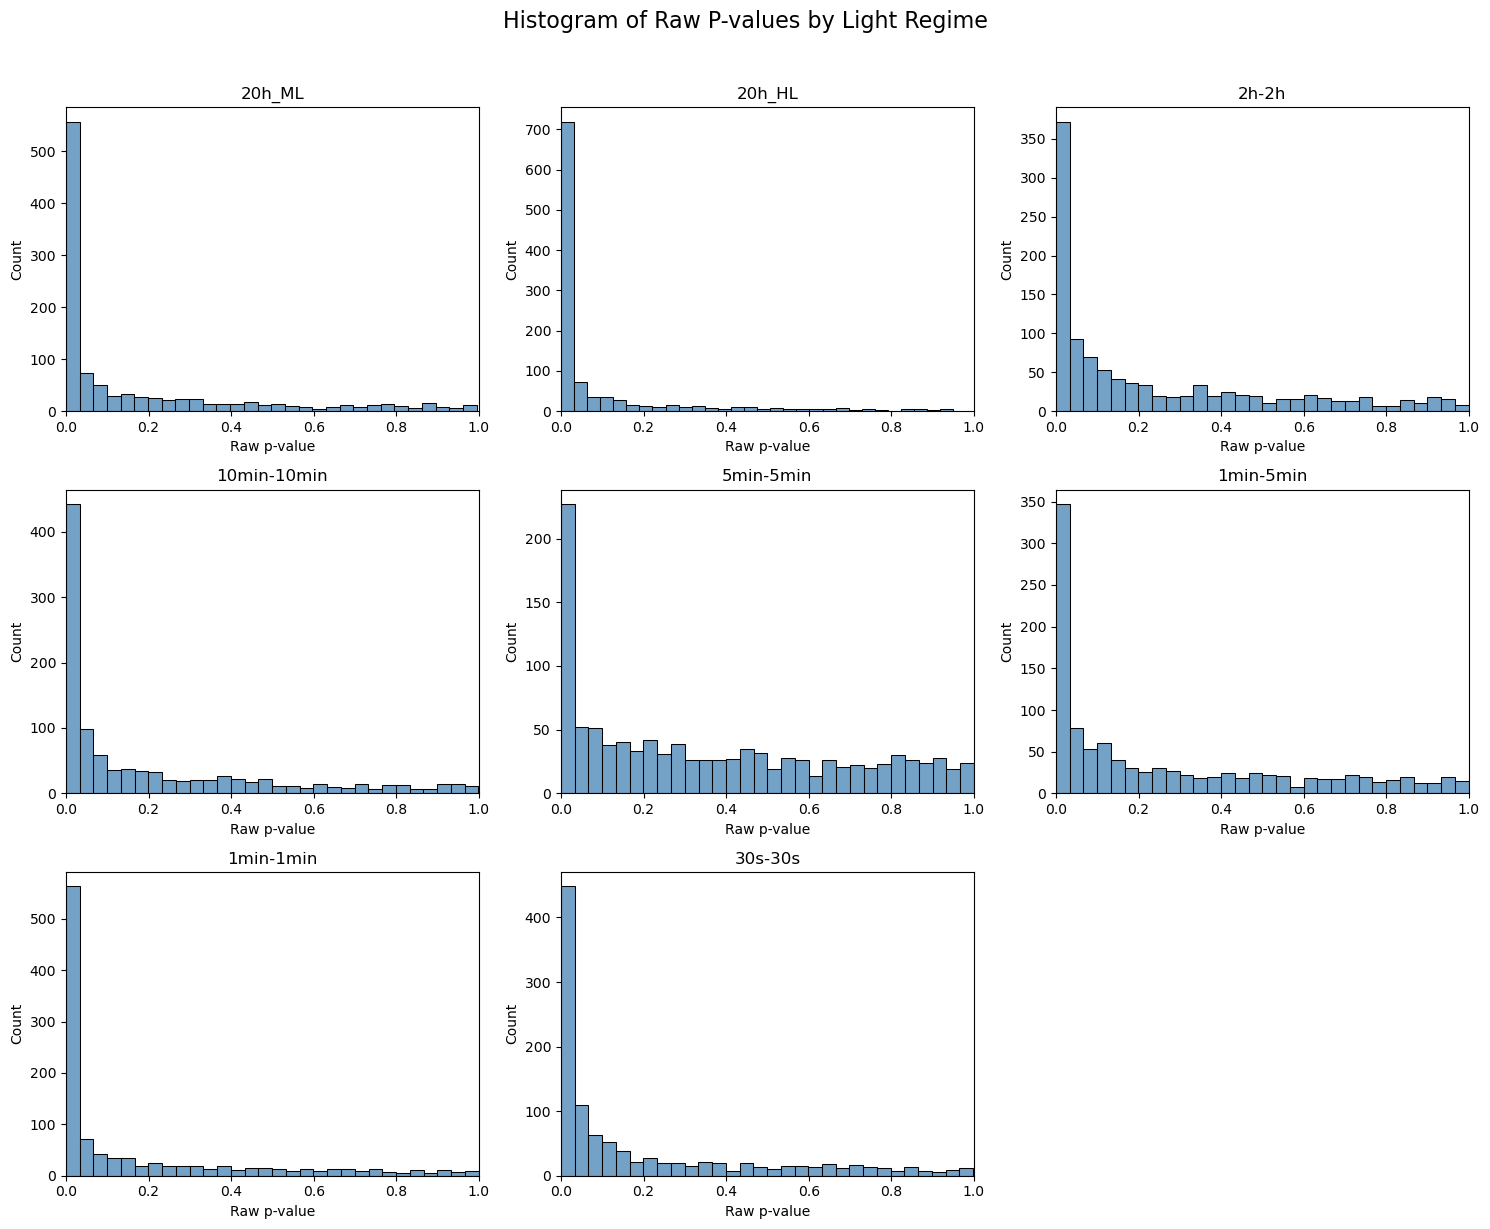

In [10]:
plot_pvalue_histograms_per_regime(epb_by_regime)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_9286/13626703.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


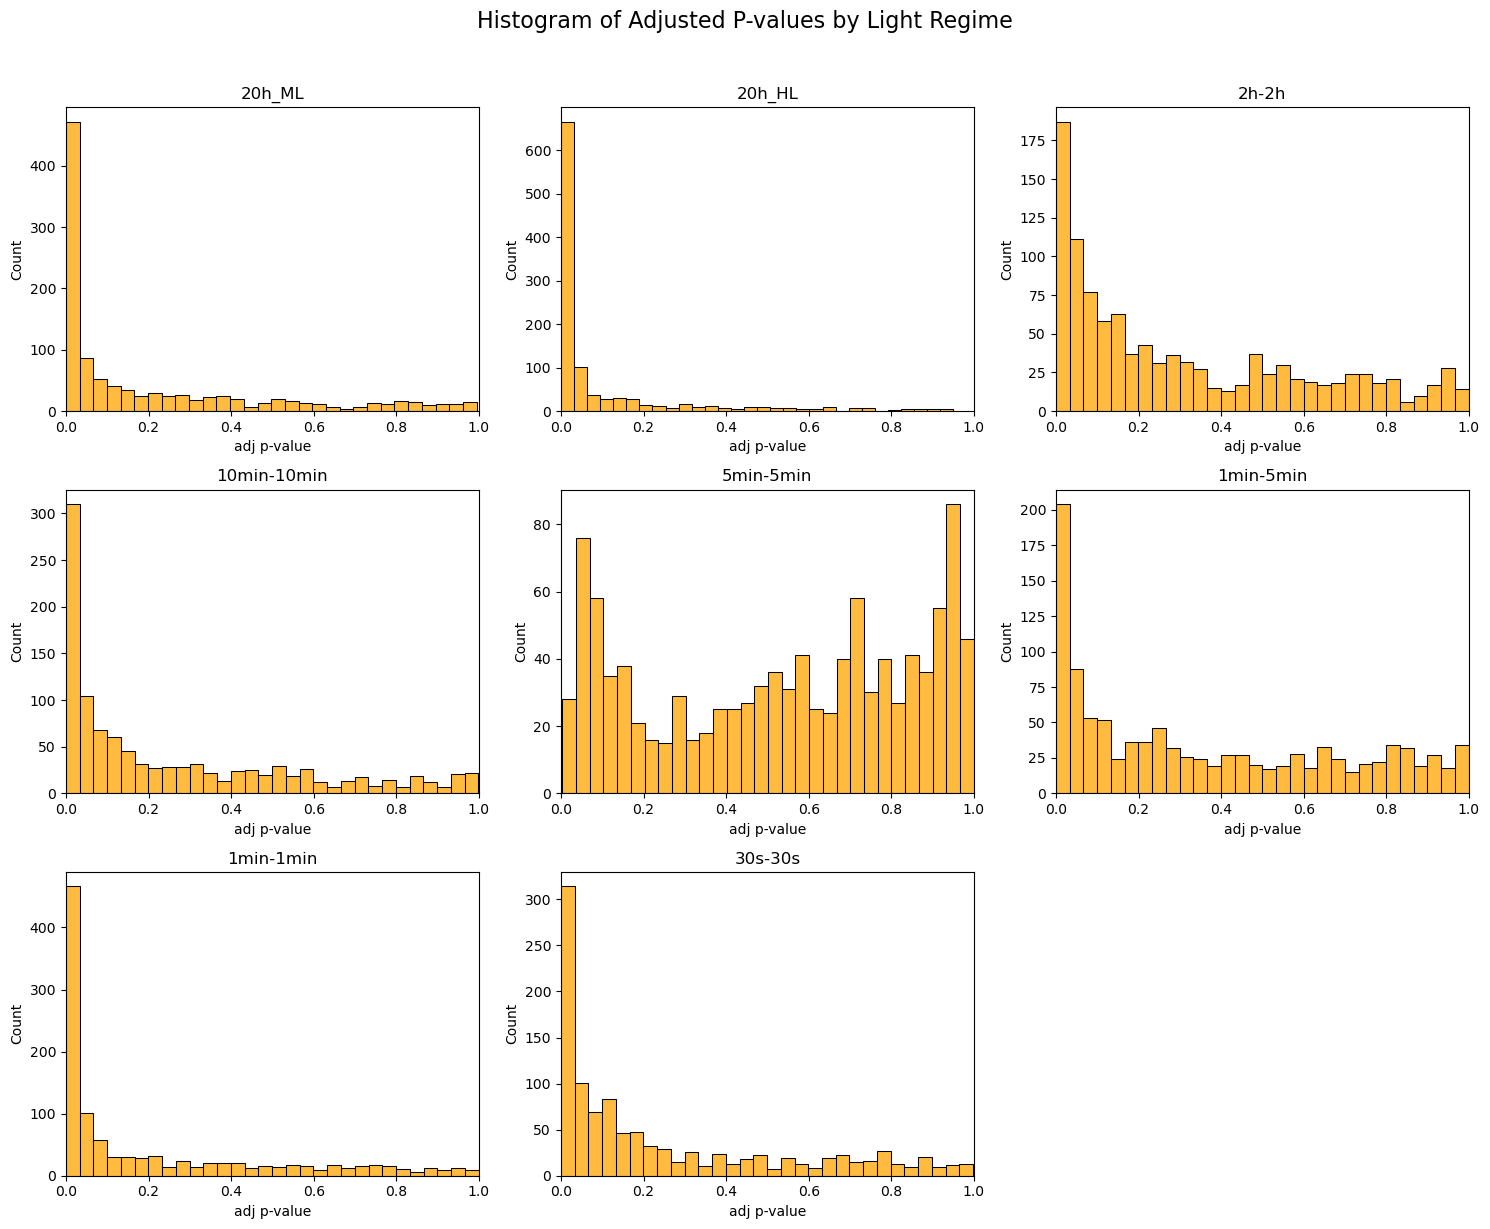

In [13]:
plot_BH_pvalue_histograms_per_regime(epb_by_regime)

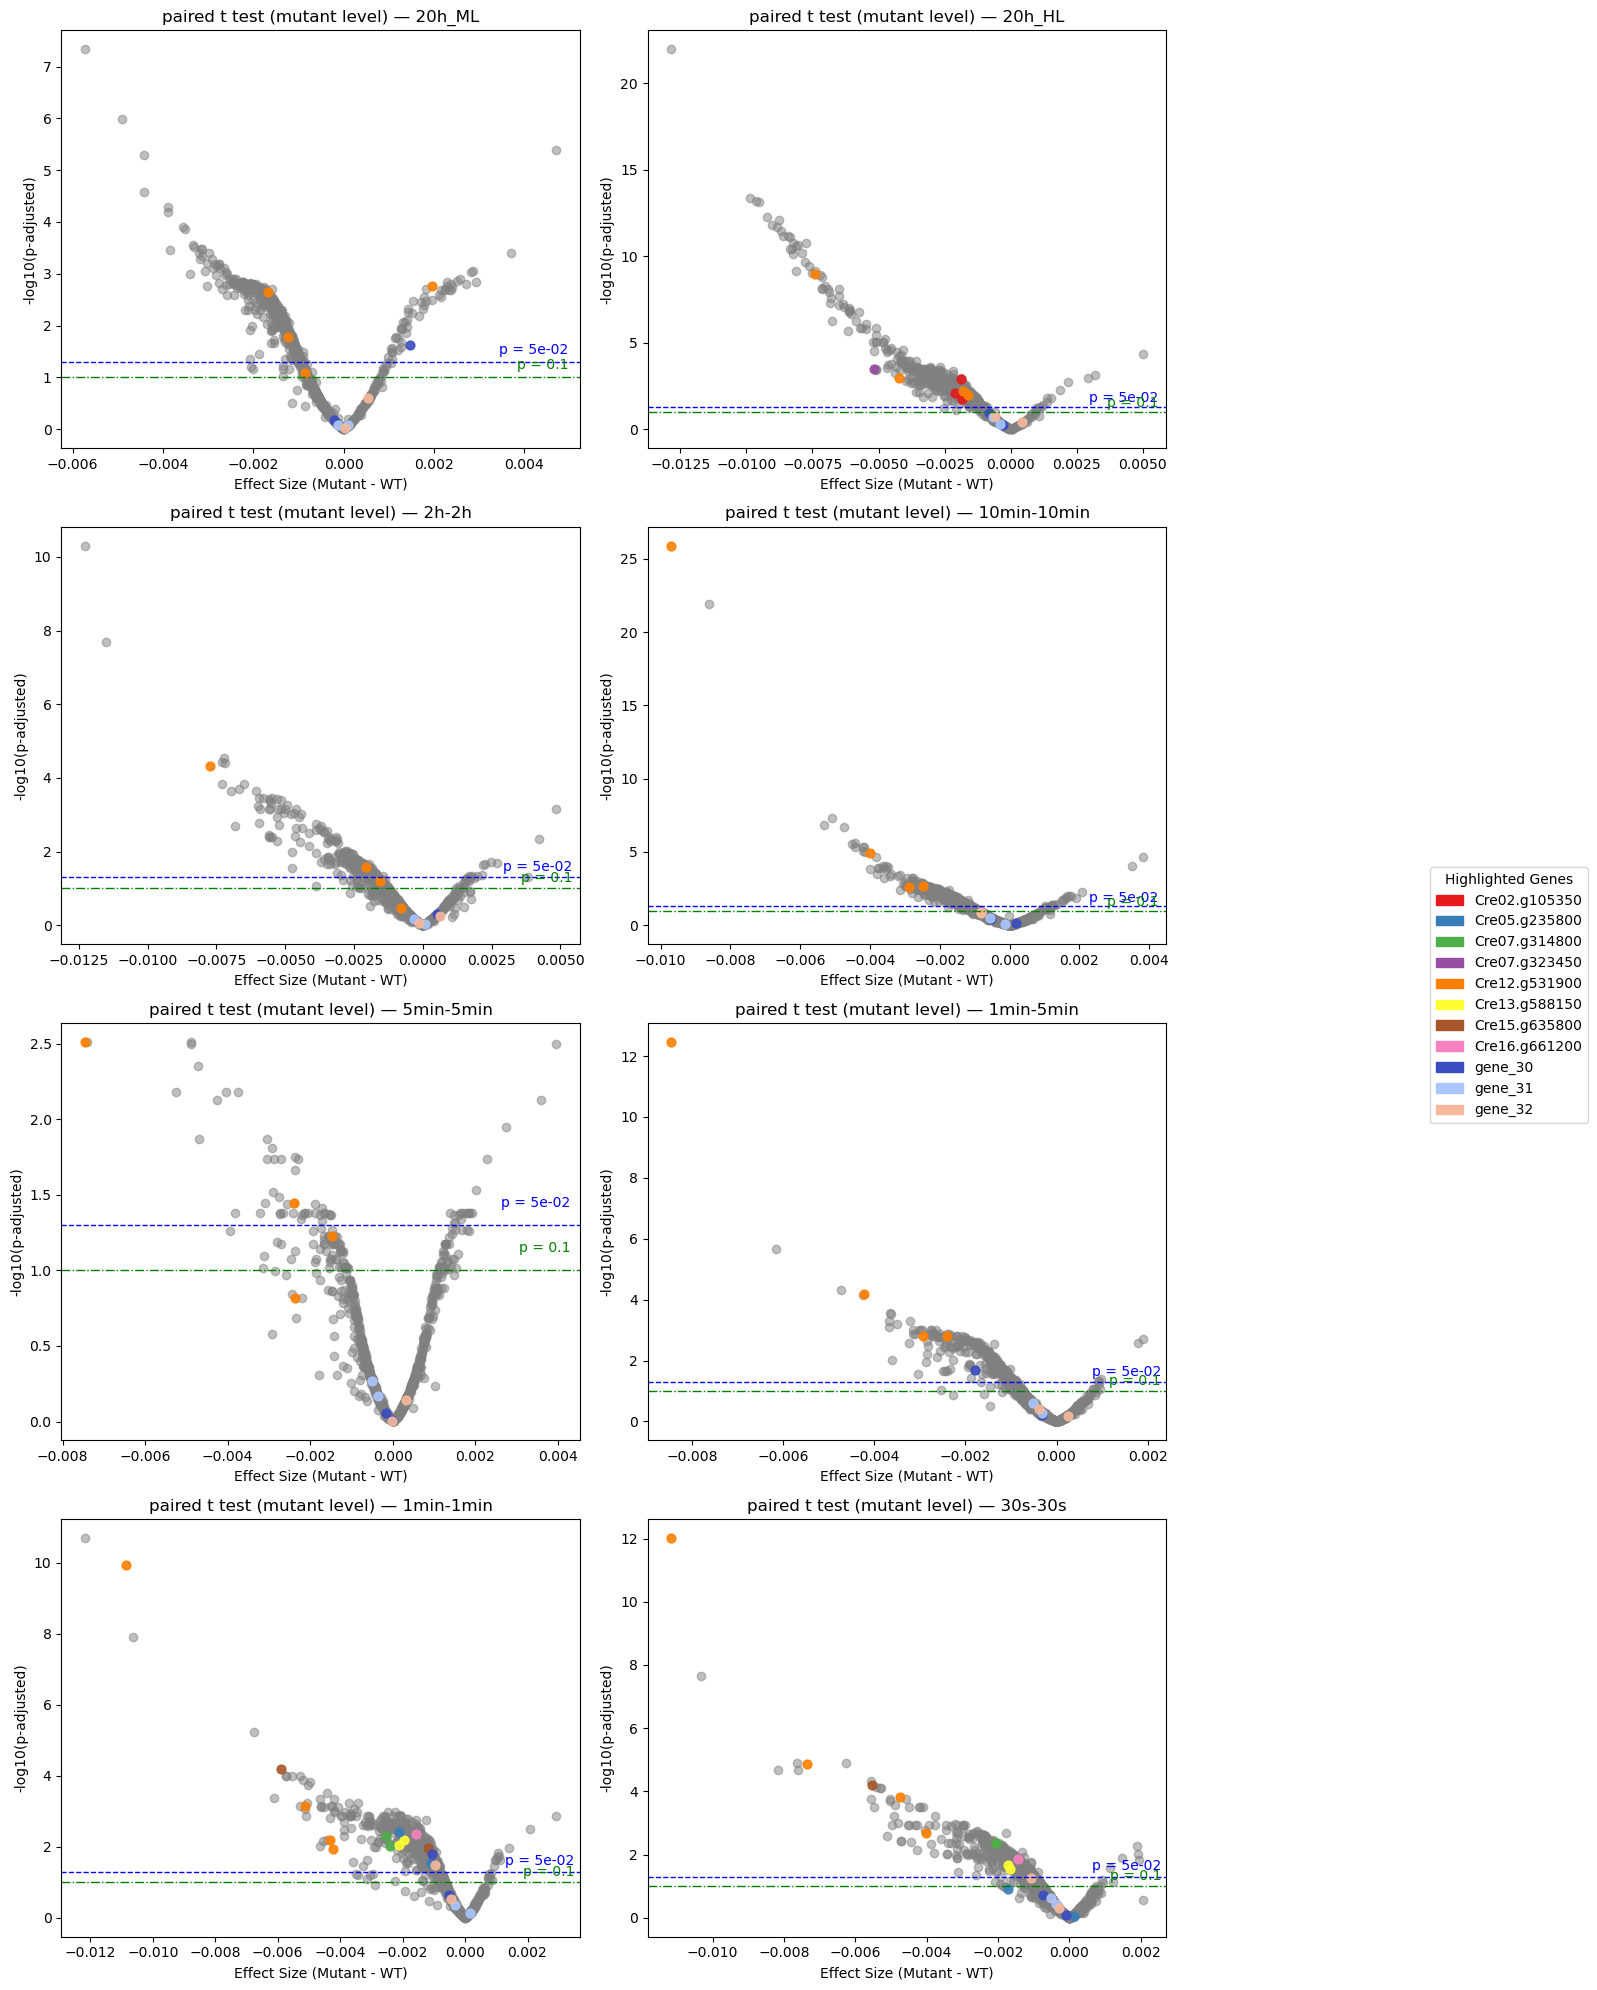

In [16]:
plot_volcano_per_light_regime1(
    epb_by_regime,
    p_thresh=0.05,
    regimes_order=['20h_ML', '20h_HL', '2h-2h', '10min-10min', '5min-5min', '1min-5min', '1min-1min', '30s-30s'],
    title_prefix='paired t test (mutant level)'
)

In [24]:
emp_fdr_df5= compute_emp_fdr_table(epb_by_regime)
emp_fdr_df5


light_regime  TP_0.05  FP_0.05  EmpFDR_0.05  mutant_0.05  gene_0.05  TP_0.1  \
0       20h_ML      521        1     0.001916            0          0     610   
1       20h_HL      737        0     0.000000            4          2     808   
2        2h-2h      233        0     0.000000            0          0     376   
3  10min-10min      366        0     0.000000            0          0     482   
4    5min-5min       63        0     0.000000            0          0     161   
5    1min-5min      255        1     0.003906            0          0     344   
6    1min-1min      526        2     0.003788           13          6     625   
7      30s-30s      365        0     0.000000           10          5     483   

   FP_0.1  EmpFDR_0.1  mutant_0.1  gene_0.1  
0       1    0.001637           0         0  
1       0    0.000000           4         2  
2       0    0.000000           0         0  
3       0    0.000000           0         0  
4       0    0.000000           0         0  
5       1    0.002899           0         0  
6       2    0.003190          13         6  
7       1    0.002066          10         5

## paired t test (gene)

In [43]:
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

paired_gene_results = []

group_keys = ['mutated_genes', 'light_regime']
grouped = mutant_df.groupby(group_keys)

for (gene, regime), group in grouped:
    group = group[['plate', 'y2_slope_select']].dropna()
    if group.empty:
        continue

    # Group by plate: for each plate with this gene, get the mean slope of mutants
    gene_plate_means = group.groupby('plate')['y2_slope_select'].mean()

    deltas = []
    for plate, gene_mean in gene_plate_means.items():
        # Get corresponding WT mean for that plate and regime
        wt_vals = wt_df[
            (wt_df['light_regime'] == regime) &
            (wt_df['plate'] == plate)
        ]['y2_slope_select'].dropna()

        if wt_vals.empty:
            continue

        wt_mean = wt_vals.mean()
        delta = gene_mean - wt_mean
        deltas.append(delta)

    if len(deltas) < 2:
        continue

    t_stat, p_val = ttest_1samp(deltas, popmean=0)

    paired_gene_results.append({
        'mutated_genes': gene,
        'light_regime': regime,
        'n_plates': len(deltas),
        't_stat': t_stat,
        'p_value': p_val,
        'delta_mean': np.mean(deltas)
    })

# Create DataFrame
paired_gene_df = pd.DataFrame(paired_gene_results)

# Apply BH correction within each light regime
def apply_bh_bonf(group):
    pvals = group['p_value']
    group['p_adj'] = multipletests(pvals, method='fdr_bh')[1]
    group['p_bonf'] = multipletests(pvals, method='bonferroni')[1]
    return group

paired_gene_df = paired_gene_df.groupby('light_regime', group_keys=False).apply(apply_bh_bonf)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_13584/1460669878.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paired_gene_df = paired_gene_df.groupby('light_regime', group_keys=False).apply(apply_bh_bonf)


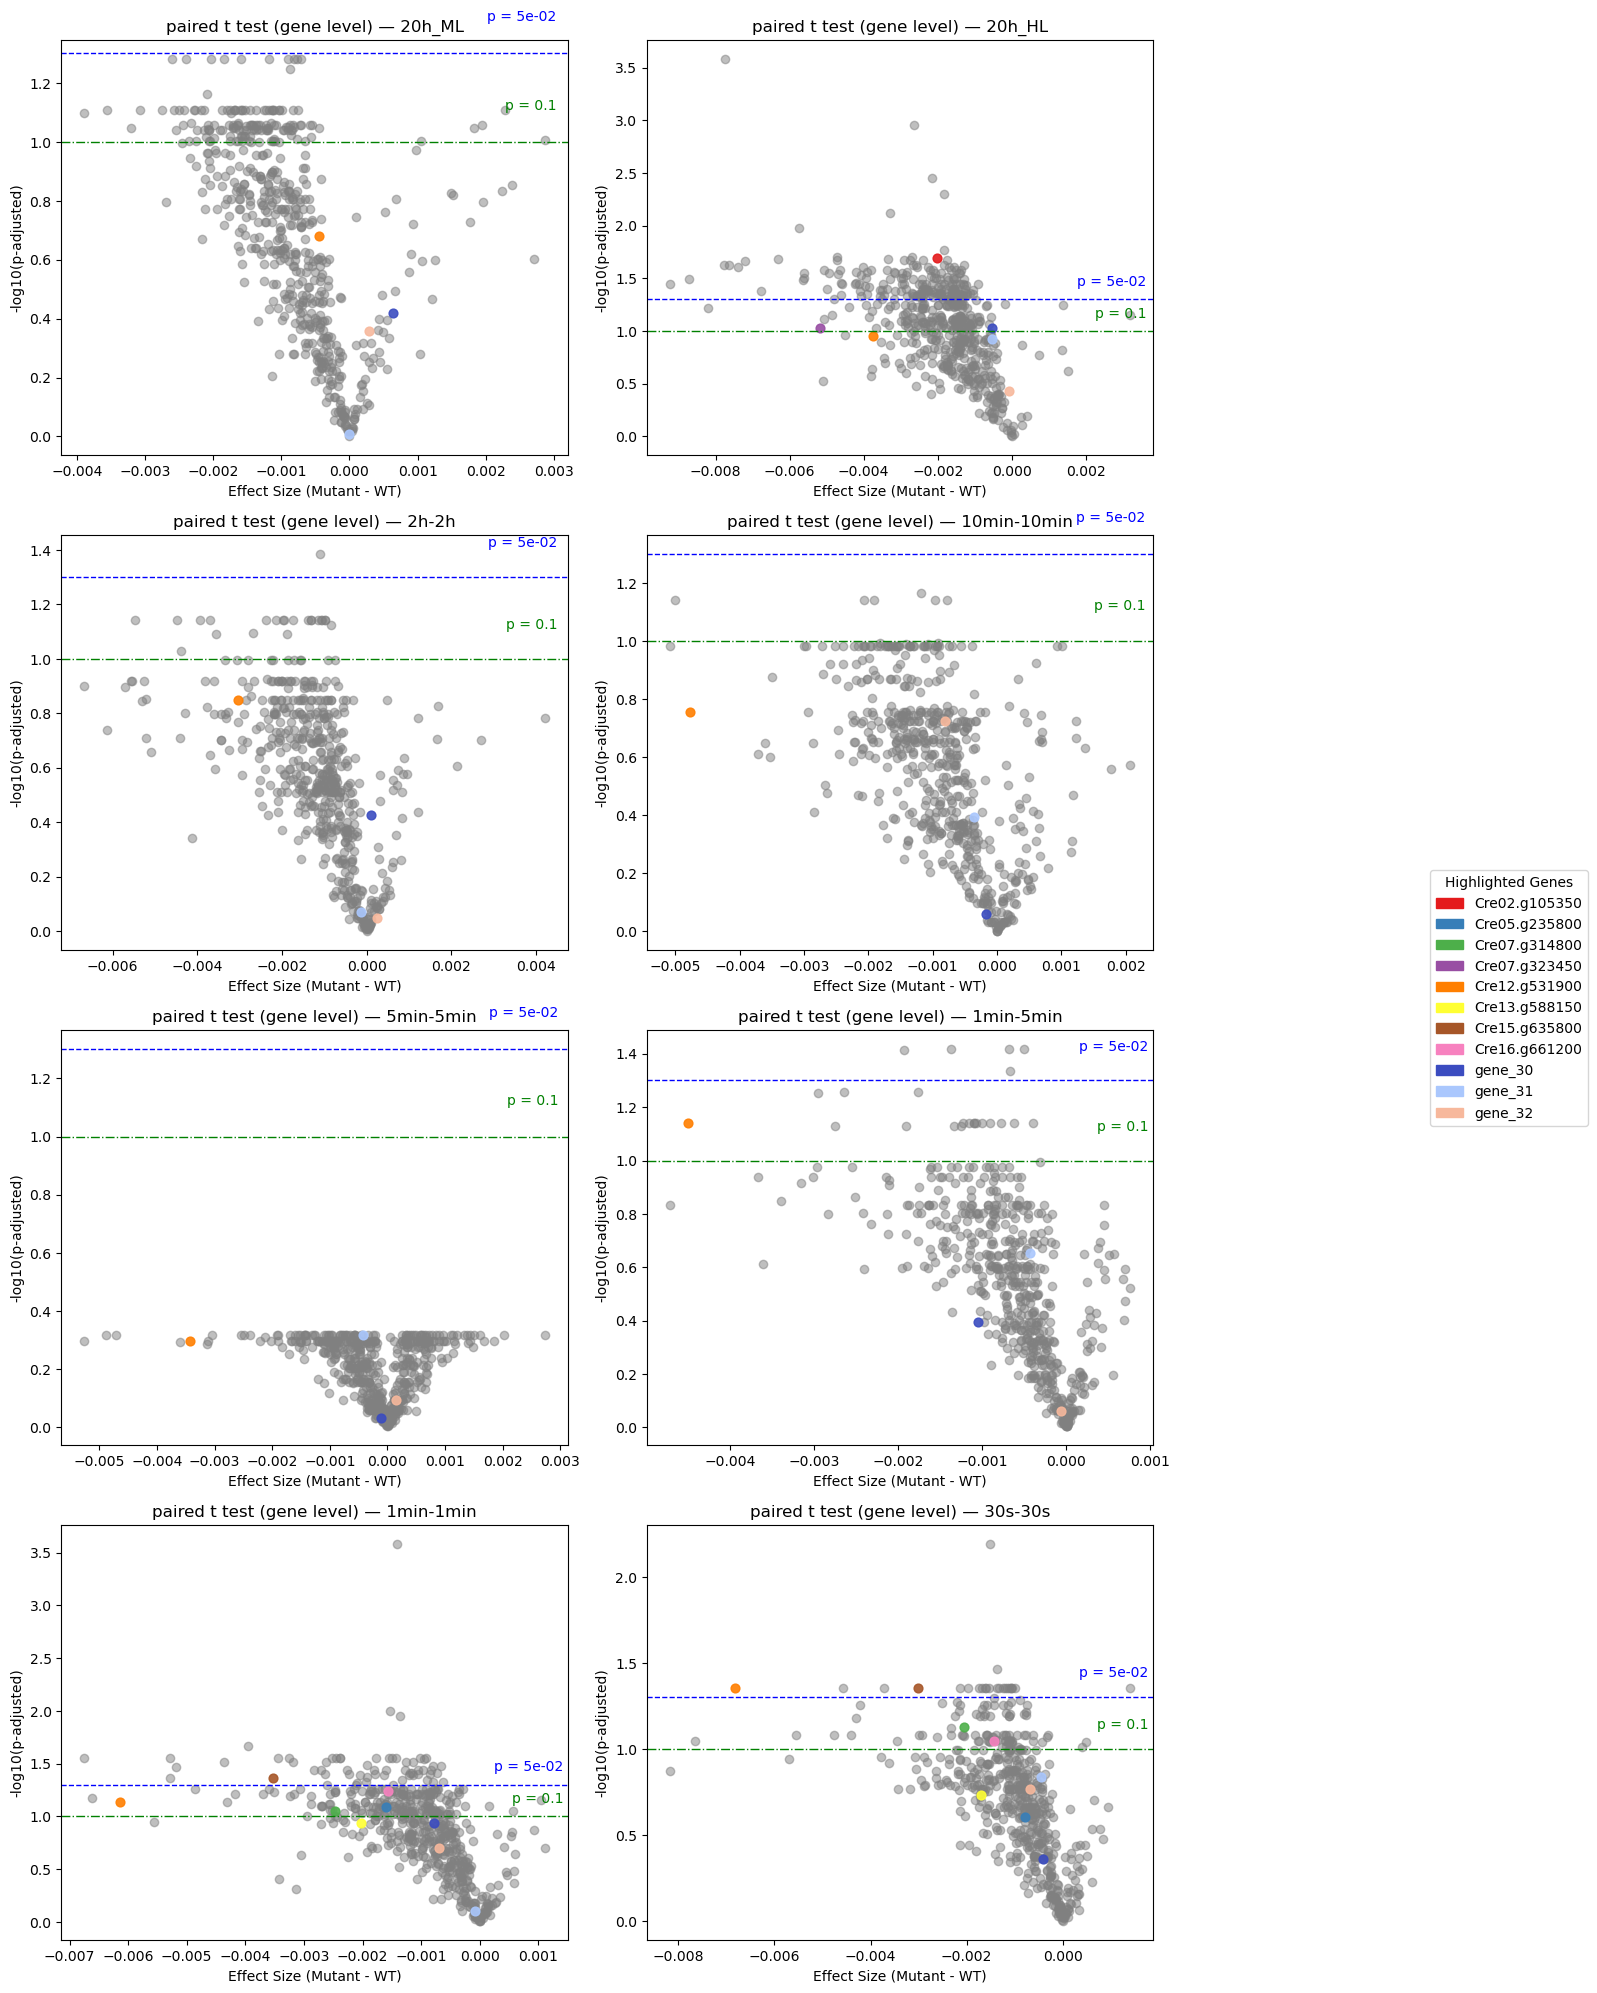

In [50]:
plot_volcano_per_light_regime1(
    paired_gene_df,
    p_thresh=0.05,
    regimes_order=['20h_ML', '20h_HL', '2h-2h', '10min-10min', '5min-5min', '1min-5min', '1min-1min', '30s-30s'],
    title_prefix='paired t test (gene level)'
)

In [32]:
expected_1min = {'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800',
                     'Cre13.g588150', 'Cre05.g235800', 'Cre15.g635800'}
expected_30s = {'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800',
                     'Cre13.g588150', 'Cre05.g235800', 'Cre15.g635800'}
expected_HL       = {'Cre02.g105350','Cre07.g323450'}

# map expected sets to light regimes (add more keys if you have more regimes)
EXPECTED_BY_REGIME = {
    "1min-1min": expected_1min,
    "30s-30s": expected_30s,
    "20h_HL":   expected_HL
}

def compute_emp_fdr_table(df_shrunk):
    def compute_emp_fdr(sub_df, alpha):
        fake_mask = sub_df['mutated_genes'].str.startswith('gene_')
        sig_mask  = sub_df['p_adj'] <= alpha
        fp = int((sig_mask & fake_mask).sum())
        tp = int((sig_mask & ~fake_mask).sum())
        fdr = fp / (fp + tp) if (fp + tp) > 0 else 0.0
        return tp, fp, fdr

    results = []
    for light_regime, sub_df in df_shrunk.groupby('light_regime'):
        # Core FDR stats
        tp_05, fp_05, fdr_05 = compute_emp_fdr(sub_df, 0.05)
        tp_10, fp_10, fdr_10 = compute_emp_fdr(sub_df, 0.10)

        # Expected gene set for this regime
        expected = set(EXPECTED_BY_REGIME.get(light_regime, set()))

        # Count how many expected genes are detected (unique, not rows)
        def count_detected_expected_genes(alpha):
            sig_rows = sub_df[sub_df['p_adj'] <= alpha]
            detected_genes = set()
            for genes_str in sig_rows['mutated_genes']:
                detected_genes.update(genes_str.split(','))
            return len(expected & detected_genes)  # intersection with expected set

        detected_expected_05 = count_detected_expected_genes(0.05)
        detected_expected_10 = count_detected_expected_genes(0.10)
        
        results.append({
            'light_regime': light_regime,
            'TP_0.05': tp_05, 'FP_0.05': fp_05, 'EmpFDR_0.05': fdr_05,
            'gene_0.05': detected_expected_05,
            'TP_0.1':  tp_10, 'FP_0.1':  fp_10, 'EmpFDR_0.1':  fdr_10,
            'gene_0.1':  detected_expected_10,
        })

    df_result = pd.DataFrame(results)

    # Custom sort order
    custom_order = ["20h_ML", "20h_HL", "2h-2h", "10min-10min","5min-5min", "1min-5min", "1min-1min","30s-30s"]
    df_result['order'] = df_result['light_regime'].map({v: i for i, v in enumerate(custom_order)})
    df_result = df_result.sort_values('order').drop(columns='order').reset_index(drop=True)

    return df_result

In [50]:
emp_fdr_df3 = compute_emp_fdr_table(paired_gene_df)
emp_fdr_df3

light_regime  TP_0.05  FP_0.05  EmpFDR_0.05  gene_0.05  TP_0.1  FP_0.1  \
0       20h_ML        0        0          0.0          0     143       0   
1       20h_HL      181        0          0.0          1     332       1   
2        2h-2h        1        0          0.0          0      23       0   
3  10min-10min        0        0          0.0          0       6       0   
4    5min-5min        0        0          0.0          0       0       0   
5    1min-5min        5        0          0.0          0      23       0   
6    1min-1min       58        0          0.0          1     250       0   
7      30s-30s       24        0          0.0          2     111       0   

   EmpFDR_0.1  gene_0.1  
0    0.000000         0  
1    0.003003         2  
2    0.000000         0  
3    0.000000         0  
4    0.000000         0  
5    0.000000         0  
6    0.000000         5  
7    0.000000         4

## shrink var: paired t test (gene)

In [15]:
import numpy as np
import pandas as pd

paired_gene_results = []

# group by gene and light regime
grouped = mutant_df.groupby(['mutated_genes', 'light_regime'])

for (gene, regime), group in grouped:
    # keep plate + value, drop missing
    group = group[['plate', 'y2_slope_select']].dropna()
    if group.empty:
        continue

    # for each plate, average all mutants of this gene (if multiple) -> one value per plate
    gene_plate_means = group.groupby('plate')['y2_slope_select'].mean()

    deltas = []
    for plate, gene_mean in gene_plate_means.items():
        # WT mean on the same plate & regime
        wt_vals = wt_df[
            (wt_df['light_regime'] == regime) &
            (wt_df['plate'] == plate)
        ]['y2_slope_select'].dropna()
        if wt_vals.empty:
            continue
        deltas.append(gene_mean - wt_vals.mean())

    # need at least 2 plates to estimate SEM
    if len(deltas) < 2:
        continue

    deltas = np.array(deltas, dtype=float)
    delta_mean = deltas.mean()
    se_hat = deltas.std(ddof=1) / np.sqrt(len(deltas))  # SEM of plate-level deltas

    paired_gene_results.append({
        'mutated_genes': gene,
        'light_regime': regime,
        'n_replicates': int(len(deltas)),   # number of plates used
        'delta_mean': float(delta_mean),
        'se_hat': float(se_hat)
    })

# DataFrame for R vash
paired_gene_df = pd.DataFrame(paired_gene_results)

In [16]:
paired_gene_df.to_csv("/Users/ruisi/Desktop/gene network/code 5.18 /phase2_shrink_var/paired_gene_for_vash_fake.csv", index=False)

In [19]:
df_shrunk1 = pd.read_csv("/Users/ruisi/Desktop/gene network/code 5.18 /phase2_shrink_var/gene_paired_delta_with_shrunk_fake_se.csv")


# Apply BH correction within each light_regime
def apply_bh(group):
    _, adj_p, _, _ = multipletests(group['p_value'], method='fdr_bh')
    group['p_adj'] = adj_p
    return group

df_shrunk1 = df_shrunk1.groupby('light_regime', group_keys=False).apply(apply_bh)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_13584/1305899755.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shrunk1 = df_shrunk1.groupby('light_regime', group_keys=False).apply(apply_bh)


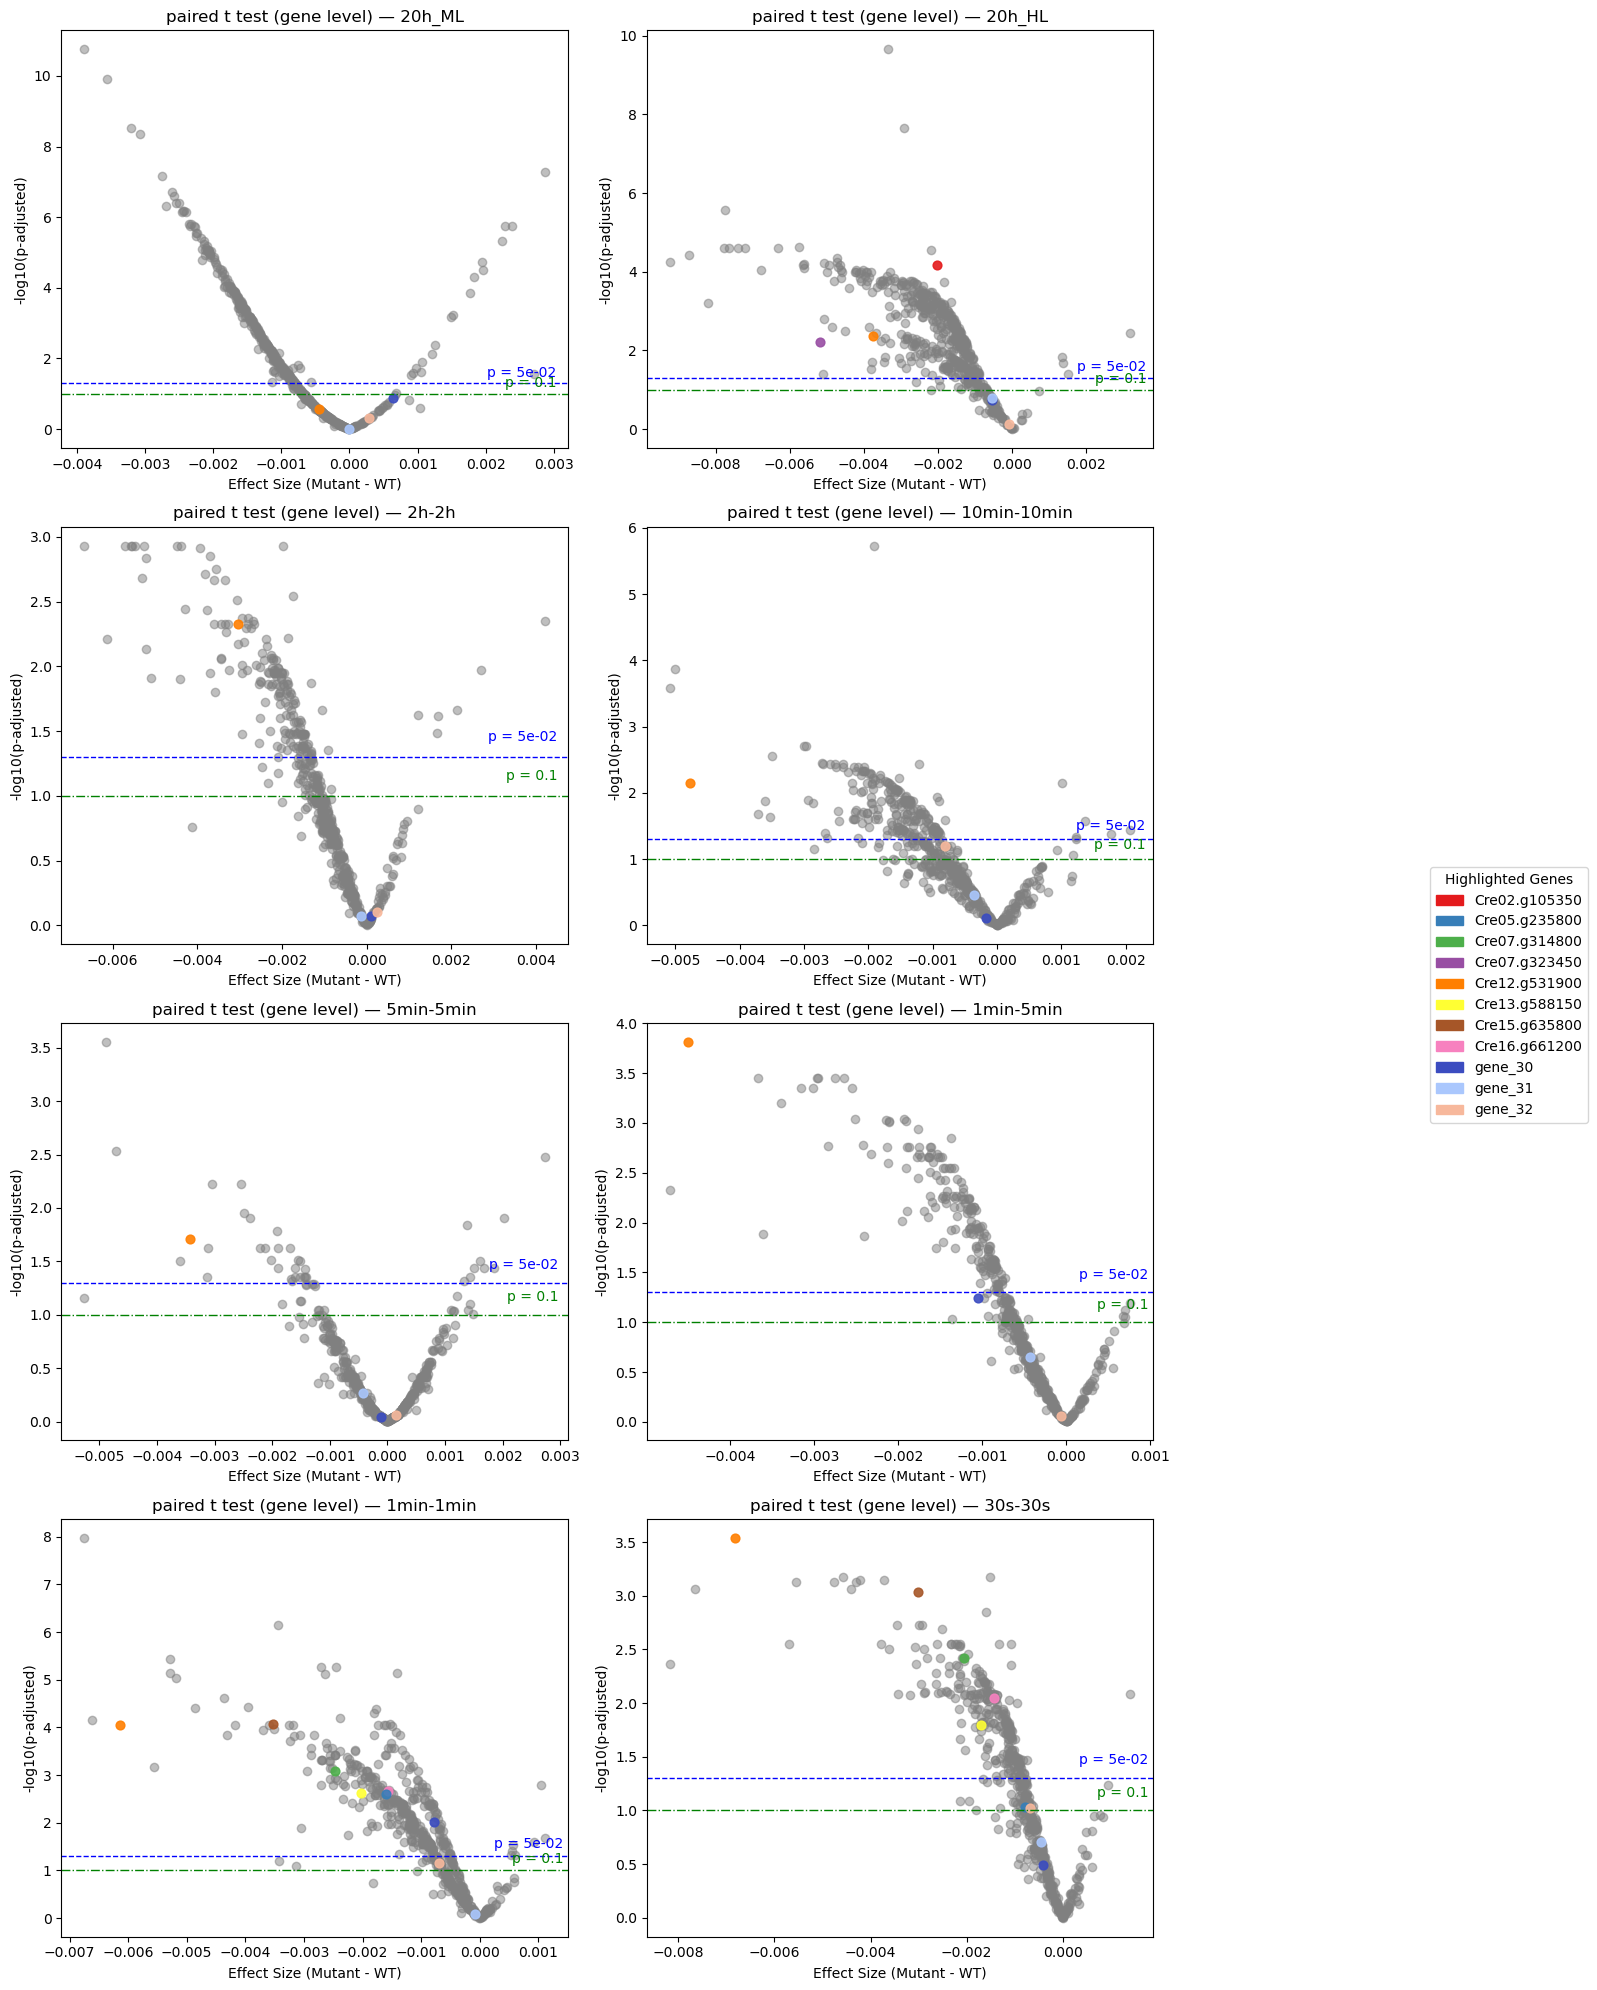

In [20]:
plot_volcano_per_light_regime1(
    df_shrunk1,
    p_thresh=0.05,
    regimes_order=['20h_ML', '20h_HL', '2h-2h', '10min-10min', '5min-5min', '1min-5min', '1min-1min', '30s-30s'],
    title_prefix='paired t test (gene level)'
)

In [51]:
emp_fdr_df4 = compute_emp_fdr_table(df_shrunk1)
emp_fdr_df4


light_regime  TP_0.05  FP_0.05  EmpFDR_0.05  gene_0.05  TP_0.1  FP_0.1  \
0       20h_ML      318        0     0.000000          0     357       0   
1       20h_HL      442        0     0.000000          2     477       0   
2        2h-2h      175        0     0.000000          0     228       0   
3  10min-10min      205        0     0.000000          0     261       1   
4    5min-5min       37        0     0.000000          0      56       0   
5    1min-5min      184        0     0.000000          0     244       1   
6    1min-1min      353        1     0.002825          6     395       2   
7      30s-30s      262        0     0.000000          5     323       1   

   EmpFDR_0.1  gene_0.1  
0    0.000000         0  
1    0.000000         2  
2    0.000000         0  
3    0.003817         0  
4    0.000000         0  
5    0.004082         0  
6    0.005038         6  
7    0.003086         6

## shrink var: piared t test (gene): fit a common prior

In [26]:
paired_gene_results = []

# group by gene and light regime
grouped = mutant_df.groupby(['mutated_genes', 'light_regime'])

for (gene, regime), group in grouped:
    # keep plate + value, drop missing
    group = group[['plate', 'y2_slope_select']].dropna()
    if group.empty:
        continue

    # for each plate, average all mutants of this gene (if multiple) -> one value per plate
    gene_plate_means = group.groupby('plate')['y2_slope_select'].mean()

    deltas = []
    for plate, gene_mean in gene_plate_means.items():
        # WT mean on the same plate & regime
        wt_vals = wt_df[
            (wt_df['light_regime'] == regime) &
            (wt_df['plate'] == plate)
        ]['y2_slope_select'].dropna()
        if wt_vals.empty:
            continue
        deltas.append(gene_mean - wt_vals.mean())

    # need at least 2 plates to estimate SEM
    if len(deltas) < 2:
        continue

    deltas = np.array(deltas, dtype=float)
    delta_mean = deltas.mean()
    se_hat = deltas.std(ddof=1) / np.sqrt(len(deltas))  # SEM of plate-level deltas

    paired_gene_results.append({
        'mutated_genes': gene,
        'light_regime': regime,
        'n_replicates': int(len(deltas)),   # number of plates used
        'delta_mean': float(delta_mean),
        'se_hat': float(se_hat)
    })

# DataFrame for R vash
paired_gene_df = pd.DataFrame(paired_gene_results)

In [27]:
paired_gene_df = pd.DataFrame(paired_gene_results).copy()
paired_gene_df["df"] = paired_gene_df["n_replicates"] - 1
paired_gene_df["se_hat_sq"] = (paired_gene_df["se_hat"] ** 2)

# guard against zero/NaN SEs
paired_gene_df.loc[~np.isfinite(paired_gene_df["se_hat_sq"]) | (paired_gene_df["se_hat_sq"] <= 0), "se_hat_sq"] = 1e-12
paired_gene_df.loc[paired_gene_df["df"] < 1, "df"] = 1  # should already be ≥1, but just in case

In [28]:

fits = {}          
rows = []

for regime, g in paired_gene_df.groupby("light_regime"):
    r = eb.epb_ttest(
        beta_hat=g["delta_mean"].to_numpy(),
        se_hat_squared=g["se_hat_sq"].to_numpy(),
        df=g["df"].to_numpy(),
        alpha=0.05,
    )
    fits[regime] = r

    g = g.copy()
    g["p_value"] = getattr(r, "pvalues", np.nan)
    g["p_adj"]   = getattr(r, "adj_pvalues", np.nan)
    rows.append(g)

epb_by_regime1 = pd.concat(rows, ignore_index=True)


 iter        p_obj        d_obj |  abs_gap    x_feas    z_feas |      tau       kap        mu | dir_res     prox  step     alpha
    0   4.3477e-02  -1.8144e+02 | 1.43e+03  9.46e+01  1.42e+00 | 1.00e+00  1.00e+00  1.00e+00 |
    1  -2.8865e+00  -1.8764e+02 | 1.28e+03  9.64e+01  1.45e+00 | 8.83e-01  1.02e+00  9.00e-01 | 1.3e-12  3.3e-01  co-a  1.00e-01
    2  -6.8184e+00  -1.9324e+02 | 1.16e+03  9.73e+01  1.46e+00 | 7.87e-01  1.03e+00  8.10e-01 | 2.6e-13  2.3e-01  co-a  1.00e-01
    3  -1.1858e+01  -1.9906e+02 | 1.04e+03  9.78e+01  1.47e+00 | 7.05e-01  1.03e+00  7.29e-01 | 1.3e-12  5.9e-02  co-a  1.00e-01
    4  -3.9771e+01  -2.2616e+02 | 7.28e+02  9.77e+01  1.47e+00 | 4.94e-01  1.04e+00  5.10e-01 | 2.0e-12  7.5e-01  co-a  3.00e-01
    5  -1.1240e+02  -2.9805e+02 | 5.10e+02  9.78e+01  1.47e+00 | 3.46e-01  1.03e+00  3.58e-01 | 3.1e-13  8.6e-01  co-a  3.00e-01
    6  -2.3811e+02  -4.2100e+02 | 3.57e+02  9.70e+01  1.46e+00 | 2.44e-01  1.03e+00  2.50e-01 | 2.2e-13  5.6e-01  co-a  3.00e-01


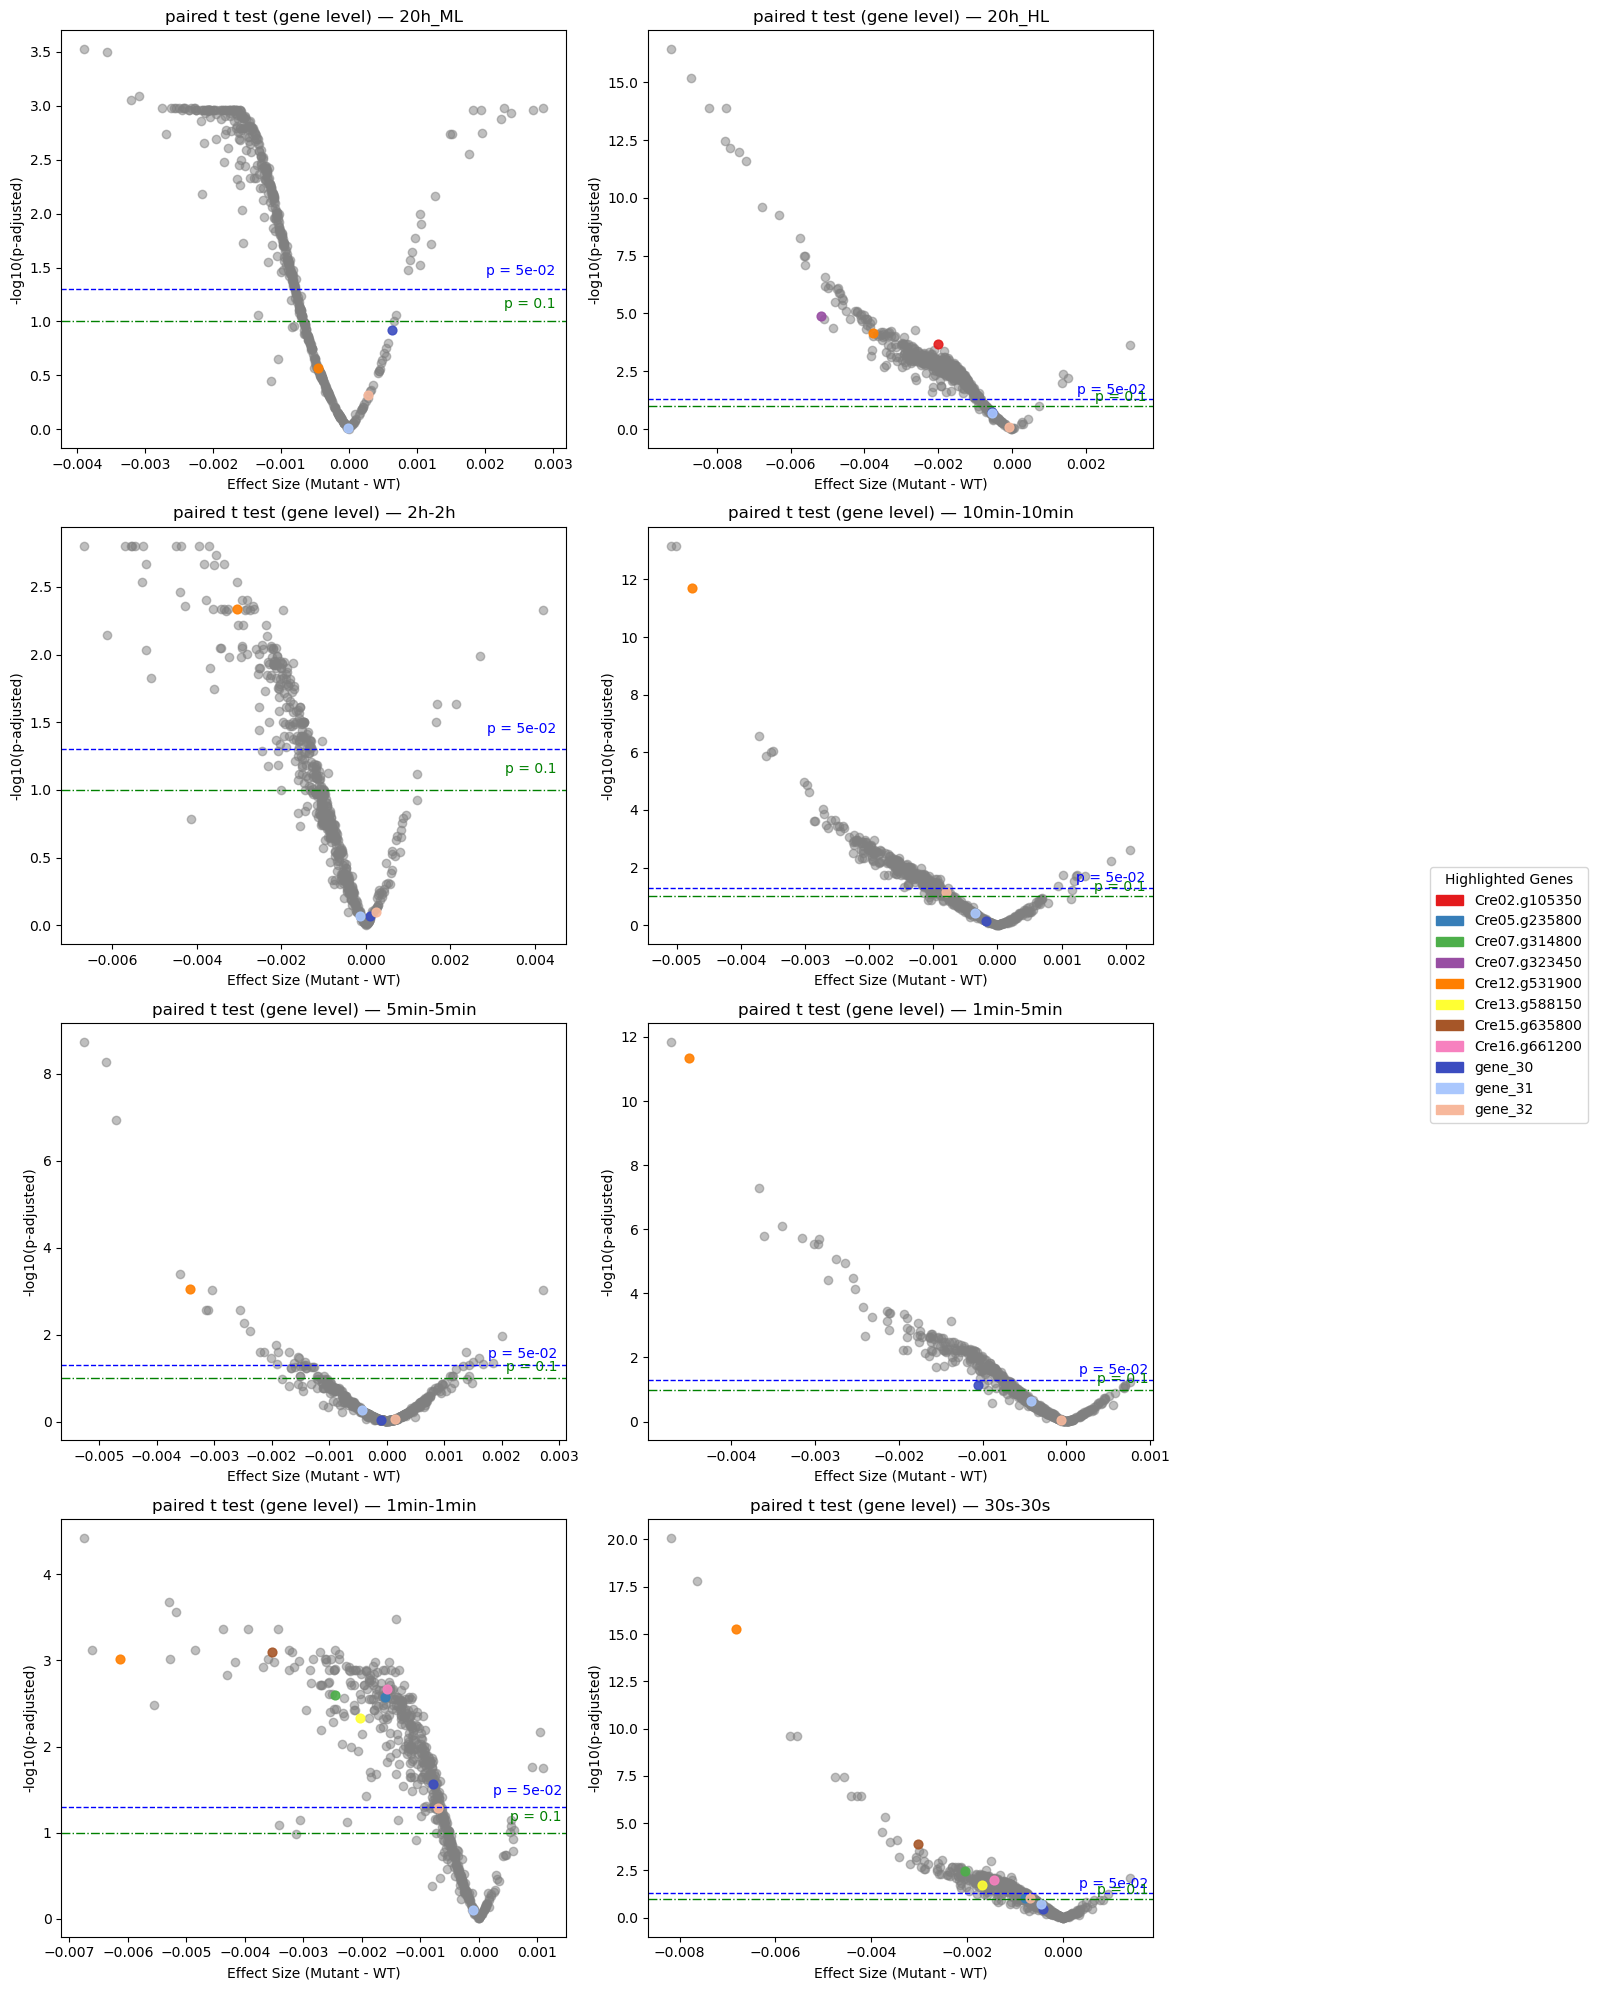

In [29]:
plot_volcano_per_light_regime1(
    epb_by_regime1,
    p_thresh=0.05,
    regimes_order=['20h_ML', '20h_HL', '2h-2h', '10min-10min', '5min-5min', '1min-5min', '1min-1min', '30s-30s'],
    title_prefix='paired t test (gene level)'
)

In [33]:
emp_fdr_df6 = compute_emp_fdr_table(epb_by_regime1)
emp_fdr_df6


light_regime  TP_0.05  FP_0.05  EmpFDR_0.05  gene_0.05  TP_0.1  FP_0.1  \
0       20h_ML      323        0     0.000000          0     360       0   
1       20h_HL      465        0     0.000000          2     481       0   
2        2h-2h      178        0     0.000000          0     233       0   
3  10min-10min      254        0     0.000000          0     314       1   
4    5min-5min       32        0     0.000000          0      53       0   
5    1min-5min      186        0     0.000000          0     246       1   
6    1min-1min      342        1     0.002915          6     392       2   
7      30s-30s      260        0     0.000000          5     323       1   

   EmpFDR_0.1  gene_0.1  
0    0.000000         0  
1    0.000000         2  
2    0.000000         0  
3    0.003175         0  
4    0.000000         0  
5    0.004049         0  
6    0.005076         6  
7    0.003086         6

## 2 sample t test (mutant, equal)

In [65]:
##  only wildtype (WT) samples from the same plates as each mutant are used in the comparison
all_results = []

# Loop through each light regime
for regime in phase2_df['light_regime'].unique():
    wt_sub = wt_df[wt_df['light_regime'] == regime]
    mutant_sub = mutant_df[mutant_df['light_regime'] == regime]

    # Loop through each unique mutant
    for (mutant_id, mutated_gene), group in mutant_sub.groupby(['mutant_ID', 'mutated_genes']):
        mutant_values = group['y2_slope_select'].dropna()

        if len(mutant_values) < 2 or np.var(mutant_values) == 0:
            continue  # skip if mutant group is too small or constant

        # Extract plates where this mutant appears
        mutant_plates = group['plate'].unique()

        # Subset WT samples on the same plates
        wt_same_plate = wt_sub[wt_sub['plate'].isin(mutant_plates)]
        wt_values = wt_same_plate['y2_slope_select'].dropna()

        if len(wt_values) < 2 or np.var(wt_values) == 0:
            continue  # skip if WT sample is too small or constant on these plates

        # Perform two-sample t-test (equal variance)
        t_stat, p_val = ttest_ind(mutant_values, wt_values, equal_var=True)

        # Append results
        all_results.append({
            'light_regime': regime,
            'mutant_ID': mutant_id,
            'mutated_genes': mutated_gene,
            't_stat': t_stat,
            'p_value': p_val,
            'mutant_mean': mutant_values.mean(),
            'wt_mean': wt_values.mean(),
            'n_mutant': len(mutant_values),
            'n_wt': len(wt_values)
        })

# Convert to DataFrame
ttest_results_all = pd.DataFrame(all_results)

# Apply Benjamini-Hochberg correction per light_regime
def apply_bh(group):
    _, adj_pvals, _, _ = multipletests(group['p_value'], method='fdr_bh')
    group['p_adj'] = adj_pvals
    return group

ttest_results_all = ttest_results_all.groupby('light_regime', group_keys=False).apply(apply_bh)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_50852/3587965657.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ttest_results_all = ttest_results_all.groupby('light_regime', group_keys=False).apply(apply_bh)


In [55]:
from matplotlib import cm
def plot_volcano_per_light_regime2(ttest_results,
                                   p_thresh=1e-5,
                                   regimes_order=None,
                                   figsize=(14, 20),
                                   title_prefix='Volcano Plot'):

    # Compute effect size and -log10(p-adj)
    ttest_results['effect_size'] = ttest_results['mutant_mean'] - ttest_results['wt_mean']
    ttest_results['neg_log10_p'] = -np.log10(ttest_results['p_adj'])

    # Define expected gene sets
    expected_ML = ['Cre12.g531900']
    expected_2h = ['Cre12.g531900']
    expected_10min = ['Cre12.g531900']
    expected_5min = ['Cre12.g531900']
    expected_1min_5min = ['Cre12.g531900']
    expected_1min = {'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800', 'Cre13.g588150', 'Cre05.g235800', 'Cre15.g635800'}
    expected_30s = expected_1min
    expected_HL = {'Cre12.g531900', 'Cre02.g105350', 'Cre07.g323450'}

    # Combine all expected genes and assign unique colors
    all_expected_genes = sorted(set.union(expected_1min, expected_30s, expected_HL))
    expected_colors = sns.color_palette('Set1', n_colors=len(all_expected_genes))
    gene_to_color = dict(zip(all_expected_genes, expected_colors))

    # Detect fake genes (e.g., gene_30, gene_31) and assign colors
    # fake_genes = sorted(g for g in ttest_results['mutated_genes'].unique() if g.startswith('gene_'))
    # fake_colors = sns.color_palette('Dark2', n_colors=len(fake_genes))
    # fake_gene_to_color = dict(zip(fake_genes, fake_colors))
    fake_genes = sorted(g for g in ttest_results['mutated_genes'].unique() if g.startswith('gene_'))
    coolwarm_colors = [cm.coolwarm(i / len(fake_genes)) for i in range(len(fake_genes))]
    fake_gene_to_color = dict(zip(fake_genes, coolwarm_colors))

    # Merge into one color mapping
    gene_to_color.update(fake_gene_to_color)
    all_expected_genes += fake_genes  # For legend

    # Determine plotting order
    if regimes_order is None:
        regimes = sorted(ttest_results['light_regime'].unique())
    else:
        regimes = regimes_order

    # Prepare subplot layout
    n = len(regimes)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, regime in enumerate(regimes):
        ax = axes[i]
        df = ttest_results[ttest_results['light_regime'] == regime].copy()

        # Determine which genes to highlight
        expected_set = (
            expected_1min if regime == '1min-1min' else
            expected_30s if regime == '30s-30s' else
            expected_HL if regime == '20h_HL' else
            expected_ML if regime == '20h_ML' else
            expected_5min if regime == '5min-5min' else
            expected_10min if regime == '10min-10min' else
            expected_1min_5min if regime == '1min-5min' else
            expected_2h if regime == '2h-2h' else
            set()
        )

        df_expected = df[df['mutated_genes'].isin(expected_set)]
        df_fake = df[df['mutated_genes'].isin(fake_genes)]
        df_others = df[
            ~df['mutated_genes'].isin(expected_set)
            & ~df['mutated_genes'].isin(fake_genes)
        ]

        # Plot background genes (non-expected, non-fake)
        ax.scatter(df_others['effect_size'], df_others['neg_log10_p'],
                   color='gray', alpha=0.5, label='_nolegend_')

        # Plot expected real genes
        for gene in expected_set:
            gene_data = df_expected[df_expected['mutated_genes'] == gene]
            if not gene_data.empty:
                ax.scatter(gene_data['effect_size'], gene_data['neg_log10_p'],
                           color=gene_to_color[gene], label=gene, s=40, alpha=0.9)

        # Plot fake genes
        for gene in fake_genes:
            gene_data = df_fake[df_fake['mutated_genes'] == gene]
            if not gene_data.empty:
                ax.scatter(gene_data['effect_size'], gene_data['neg_log10_p'],
                           color=gene_to_color[gene], label=gene, s=40, alpha=0.9)

        # Draw significance lines
        y_thresh_main = -np.log10(p_thresh)
        ax.axhline(y_thresh_main, color='blue', linestyle='--', linewidth=1)
        ax.text(
            x=0.95 * ax.get_xlim()[1],
            y=y_thresh_main + 0.1,
            s=f'p = {p_thresh:.0e}',
            color='blue',
            ha='right',
            va='bottom',
            fontsize=10
        )

        y_thresh_01 = -np.log10(0.1)
        ax.axhline(y_thresh_01, color='green', linestyle='-.', linewidth=1)
        ax.text(
            x=0.95 * ax.get_xlim()[1],
            y=y_thresh_01 + 0.1,
            s='p = 0.1',
            color='green',
            ha='right',
            va='bottom',
            fontsize=10
        )

        ax.set_title(f'{title_prefix} — {regime}')
        ax.set_xlabel('Effect Size (Mutant - WT)')
        ax.set_ylabel('-log10(p-adjusted)')

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add legend
    legend_patches = [Patch(color=gene_to_color[gene], label=gene) for gene in all_expected_genes]
    fig.legend(handles=legend_patches, title='Highlighted Genes', bbox_to_anchor=(1.02, 0.5), loc='center left')

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

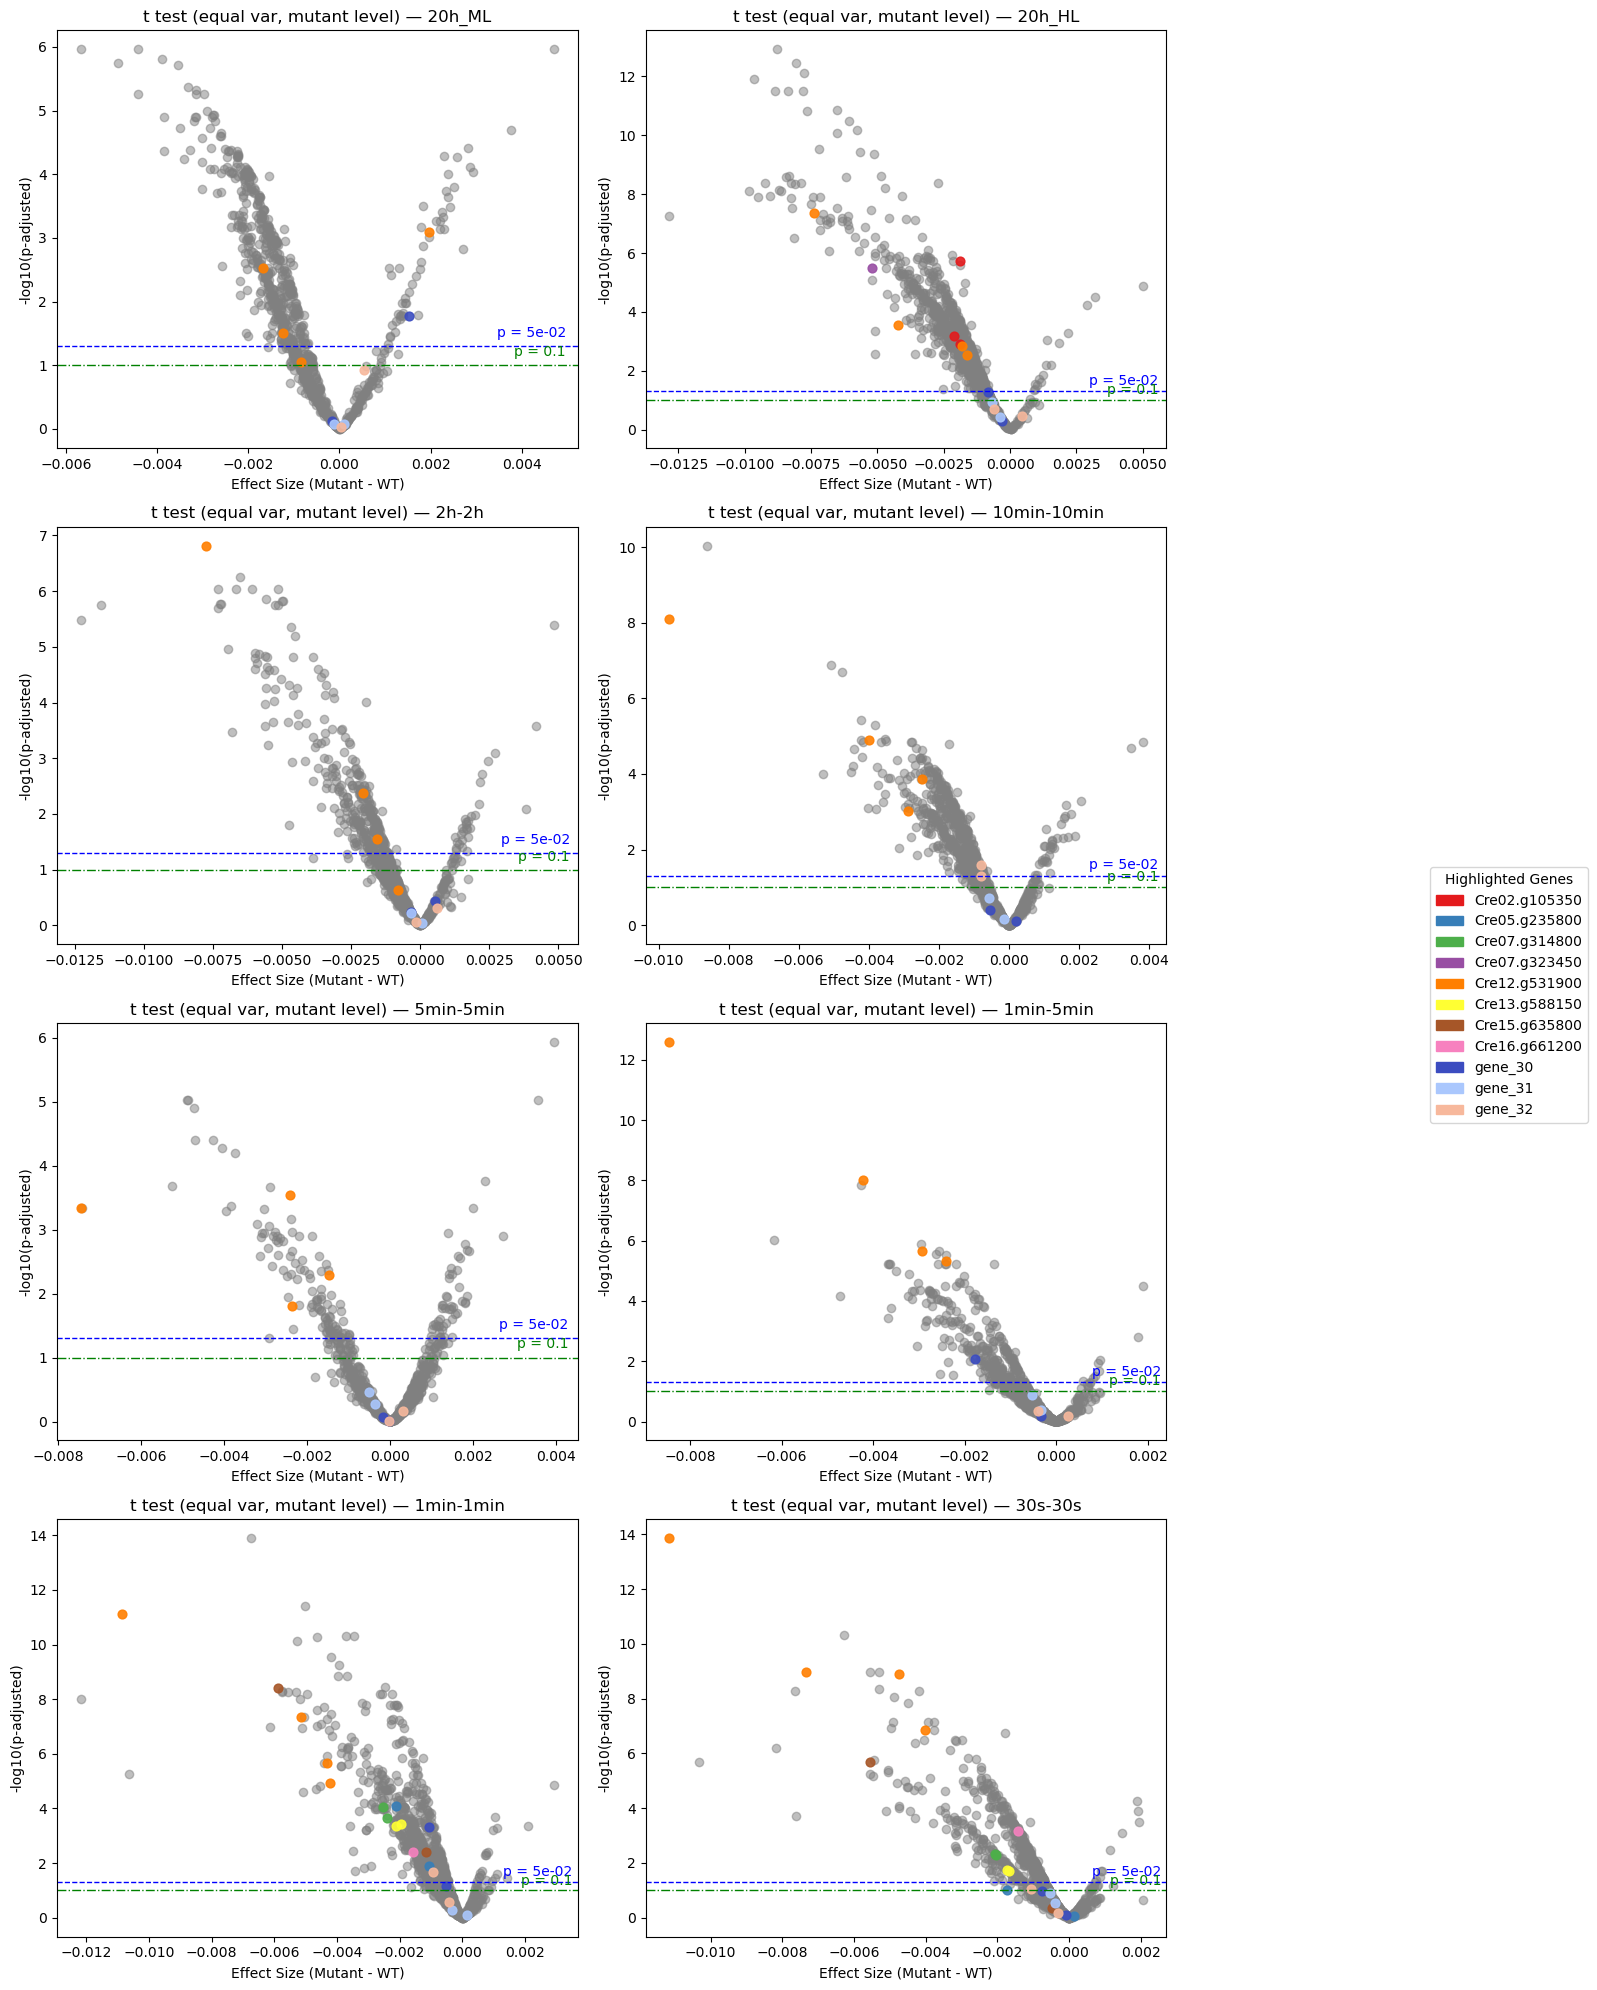

In [66]:
plot_volcano_per_light_regime2(
    ttest_results_all,
    p_thresh=0.05,
    regimes_order=['20h_ML', '20h_HL', '2h-2h', '10min-10min', '5min-5min', '1min-5min', '1min-1min', '30s-30s'],
    title_prefix='t test (equal var, mutant level)'
)

## 2 sample t test (mutant, unequal)

In [68]:
##  only wildtype (WT) samples from the same plates as each mutant are used in the comparison
all_results = []

# Loop through each light regime
for regime in phase2_df['light_regime'].unique():
    wt_sub = wt_df[wt_df['light_regime'] == regime]
    mutant_sub = mutant_df[mutant_df['light_regime'] == regime]

    # Loop through each unique mutant
    for (mutant_id, mutated_gene), group in mutant_sub.groupby(['mutant_ID', 'mutated_genes']):
        mutant_values = group['y2_slope_select'].dropna()

        if len(mutant_values) < 2 or np.var(mutant_values) == 0:
            continue  # skip if mutant group is too small or constant

        # Extract plates where this mutant appears
        mutant_plates = group['plate'].unique()

        # Subset WT samples on the same plates
        wt_same_plate = wt_sub[wt_sub['plate'].isin(mutant_plates)]
        wt_values = wt_same_plate['y2_slope_select'].dropna()

        if len(wt_values) < 2 or np.var(wt_values) == 0:
            continue  # skip if WT sample is too small or constant on these plates

        # Perform two-sample t-test (equal variance)
        t_stat, p_val = ttest_ind(mutant_values, wt_values, equal_var=False)

        # Append results
        all_results.append({
            'light_regime': regime,
            'mutant_ID': mutant_id,
            'mutated_genes': mutated_gene,
            't_stat': t_stat,
            'p_value': p_val,
            'mutant_mean': mutant_values.mean(),
            'wt_mean': wt_values.mean(),
            'n_mutant': len(mutant_values),
            'n_wt': len(wt_values)
        })

# Convert to DataFrame
ttest_results_all = pd.DataFrame(all_results)

# Apply Benjamini-Hochberg correction per light_regime
def apply_bh(group):
    _, adj_pvals, _, _ = multipletests(group['p_value'], method='fdr_bh')
    group['p_adj'] = adj_pvals
    return group

ttest_results_all = ttest_results_all.groupby('light_regime', group_keys=False).apply(apply_bh)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_50852/3156007407.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ttest_results_all = ttest_results_all.groupby('light_regime', group_keys=False).apply(apply_bh)


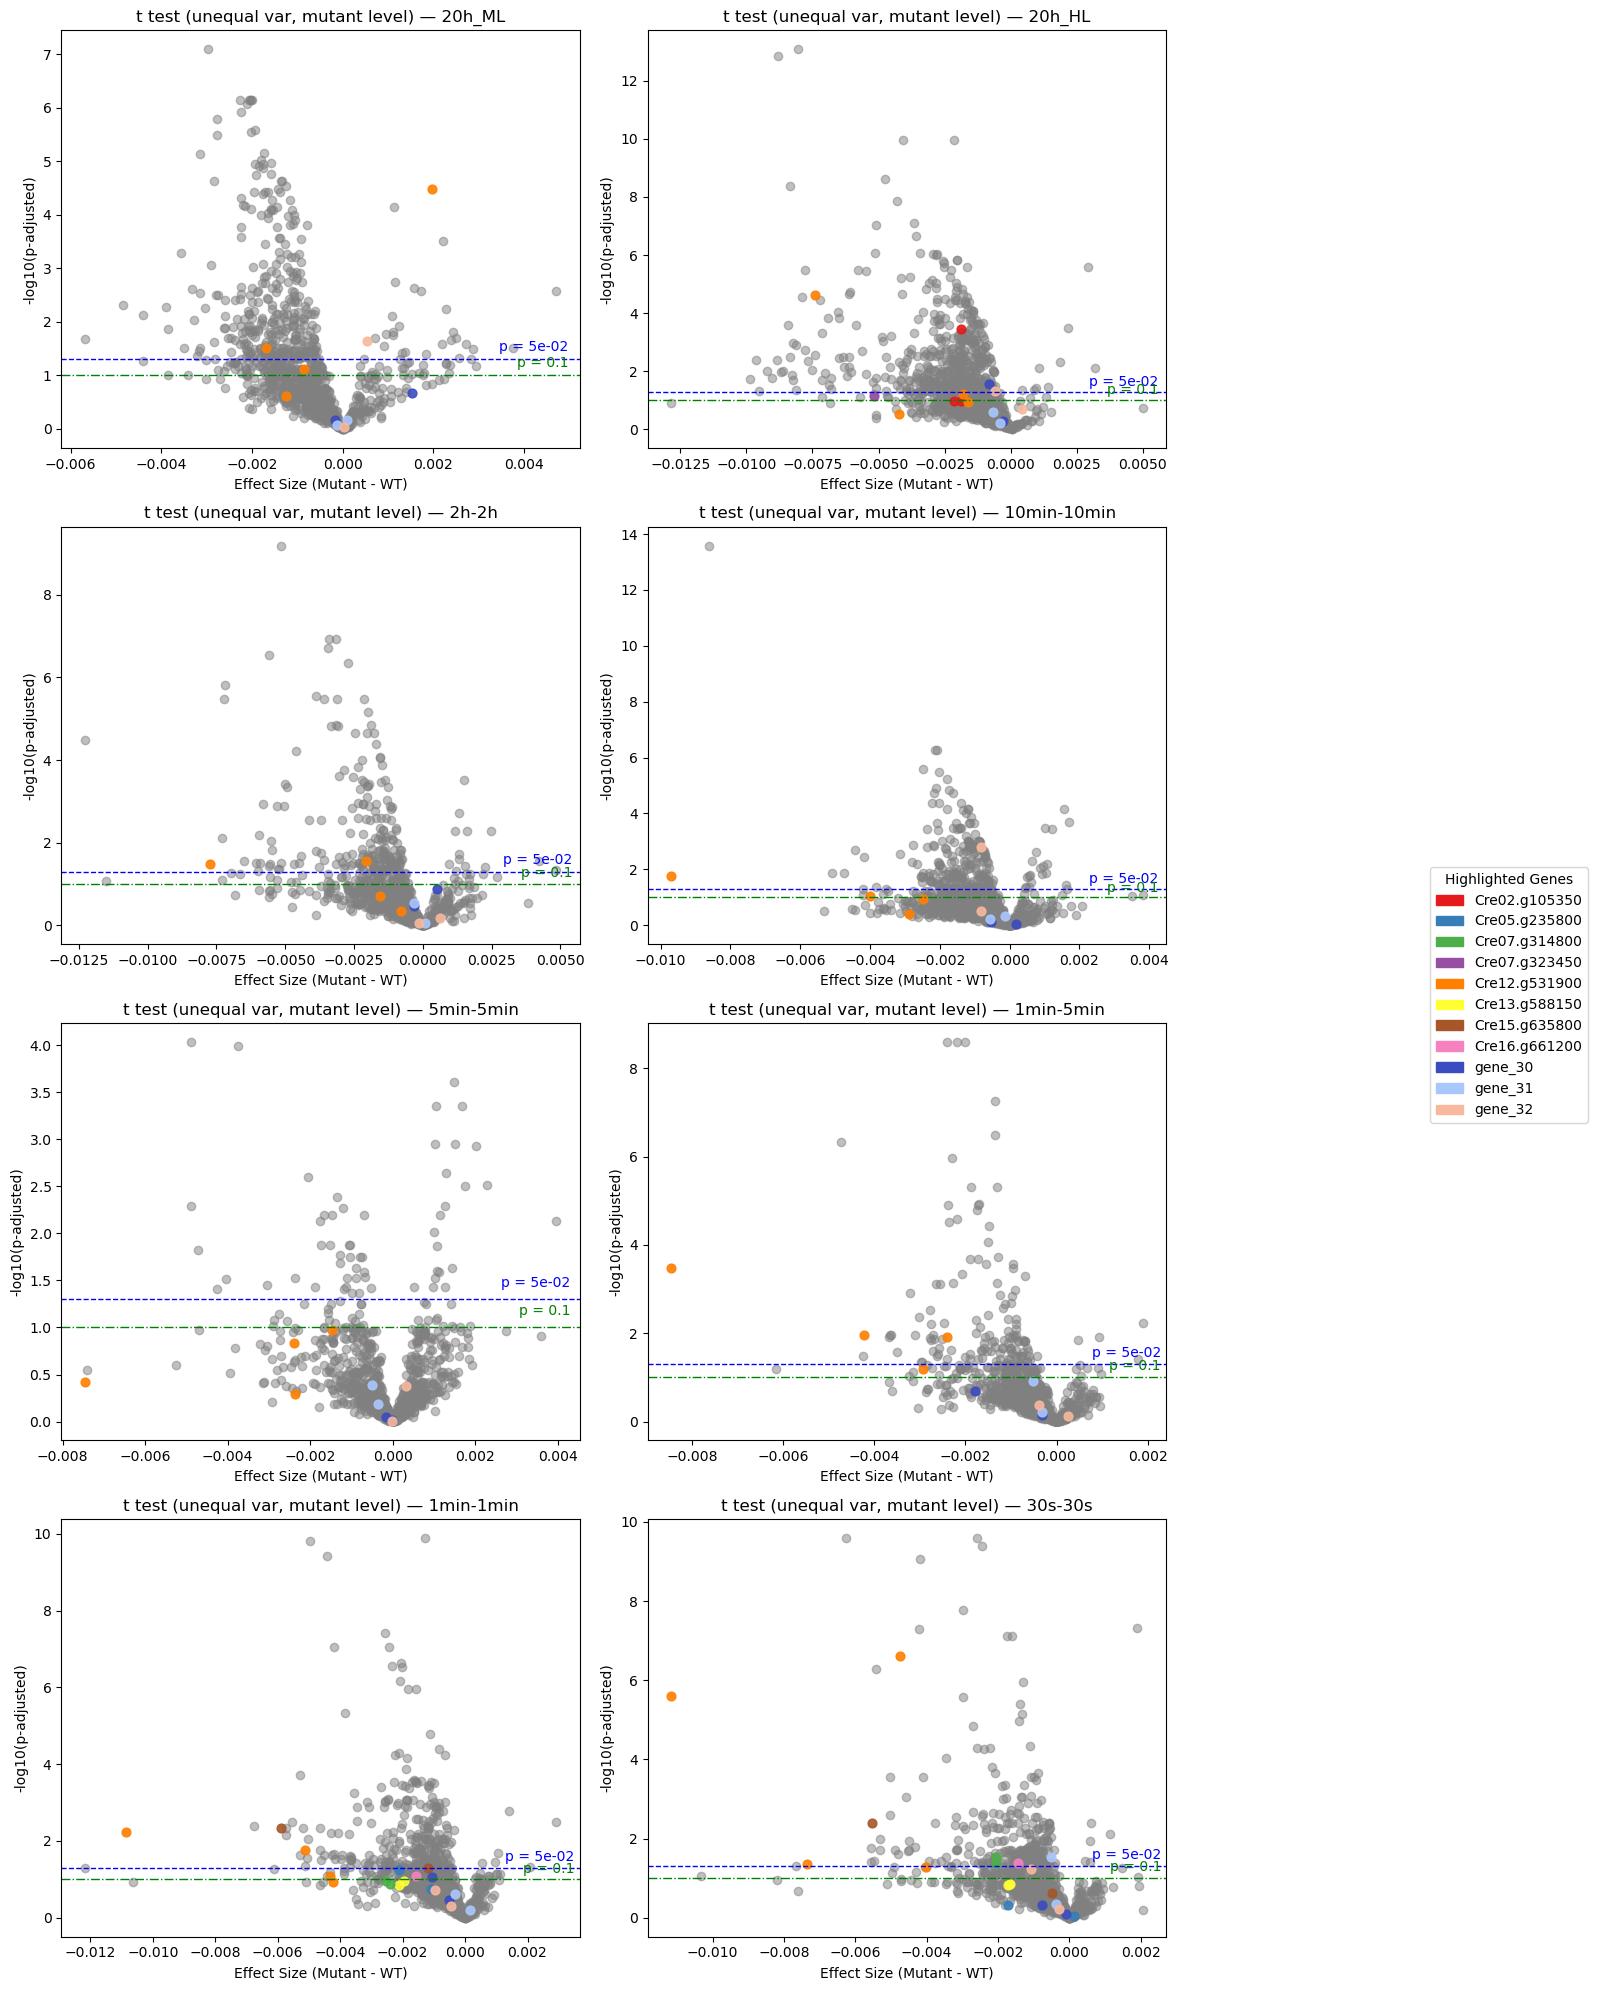

In [69]:
plot_volcano_per_light_regime2(
    ttest_results_all,
    p_thresh=0.05,
    regimes_order=['20h_ML', '20h_HL', '2h-2h', '10min-10min', '5min-5min', '1min-5min', '1min-1min', '30s-30s'],
    title_prefix='t test (unequal var, mutant level)'
)

## check : 2 sample t test (mutant, unequal , use WT mean)

In [70]:

all_results = []

# Loop through each light regime
for regime in phase2_df['light_regime'].unique():
    wt_sub = wt_df[wt_df['light_regime'] == regime]
    mutant_sub = mutant_df[mutant_df['light_regime'] == regime]

    # Loop through each unique mutant
    for (mutant_id, mutated_gene), group in mutant_sub.groupby(['mutant_ID', 'mutated_genes']):
        # Drop missing mutant values
        mutant_values = group['y2_slope_select'].dropna()
        if len(mutant_values) < 2 or np.var(mutant_values) == 0:
            continue

        # Extract plates where this mutant appears
        mutant_plates = group['plate'].unique()

        # Subset WT samples on the same plates
        wt_same_plate = wt_sub[wt_sub['plate'].isin(mutant_plates)].copy()

        # Aggregate WT by plate: take mean per plate
        wt_plate_means = wt_same_plate.groupby('plate')['y2_slope_select'].mean().dropna()
        wt_values = wt_plate_means.values

        if len(wt_values) < 2 or np.var(wt_values) == 0:
            continue

        # Perform Welch's t-test (unequal variance)
        t_stat, p_val = ttest_ind(mutant_values, wt_values, equal_var=False)

        all_results.append({
            'light_regime': regime,
            'mutant_ID': mutant_id,
            'mutated_genes': mutated_gene,
            't_stat': t_stat,
            'p_value': p_val,
            'mutant_mean': mutant_values.mean(),
            'wt_mean': wt_values.mean(),
            'n_mutant': len(mutant_values),
            'n_wt': len(wt_values)  # Now represents number of WT plates
        })

# Convert to DataFrame
ttest_results_all = pd.DataFrame(all_results)

# Apply BH correction within each light regime
def apply_bh(group):
    _, adj_pvals, _, _ = multipletests(group['p_value'], method='fdr_bh')
    group['p_adj'] = adj_pvals
    return group

ttest_results_all = ttest_results_all.groupby('light_regime', group_keys=False).apply(apply_bh)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_50852/190128747.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ttest_results_all = ttest_results_all.groupby('light_regime', group_keys=False).apply(apply_bh)


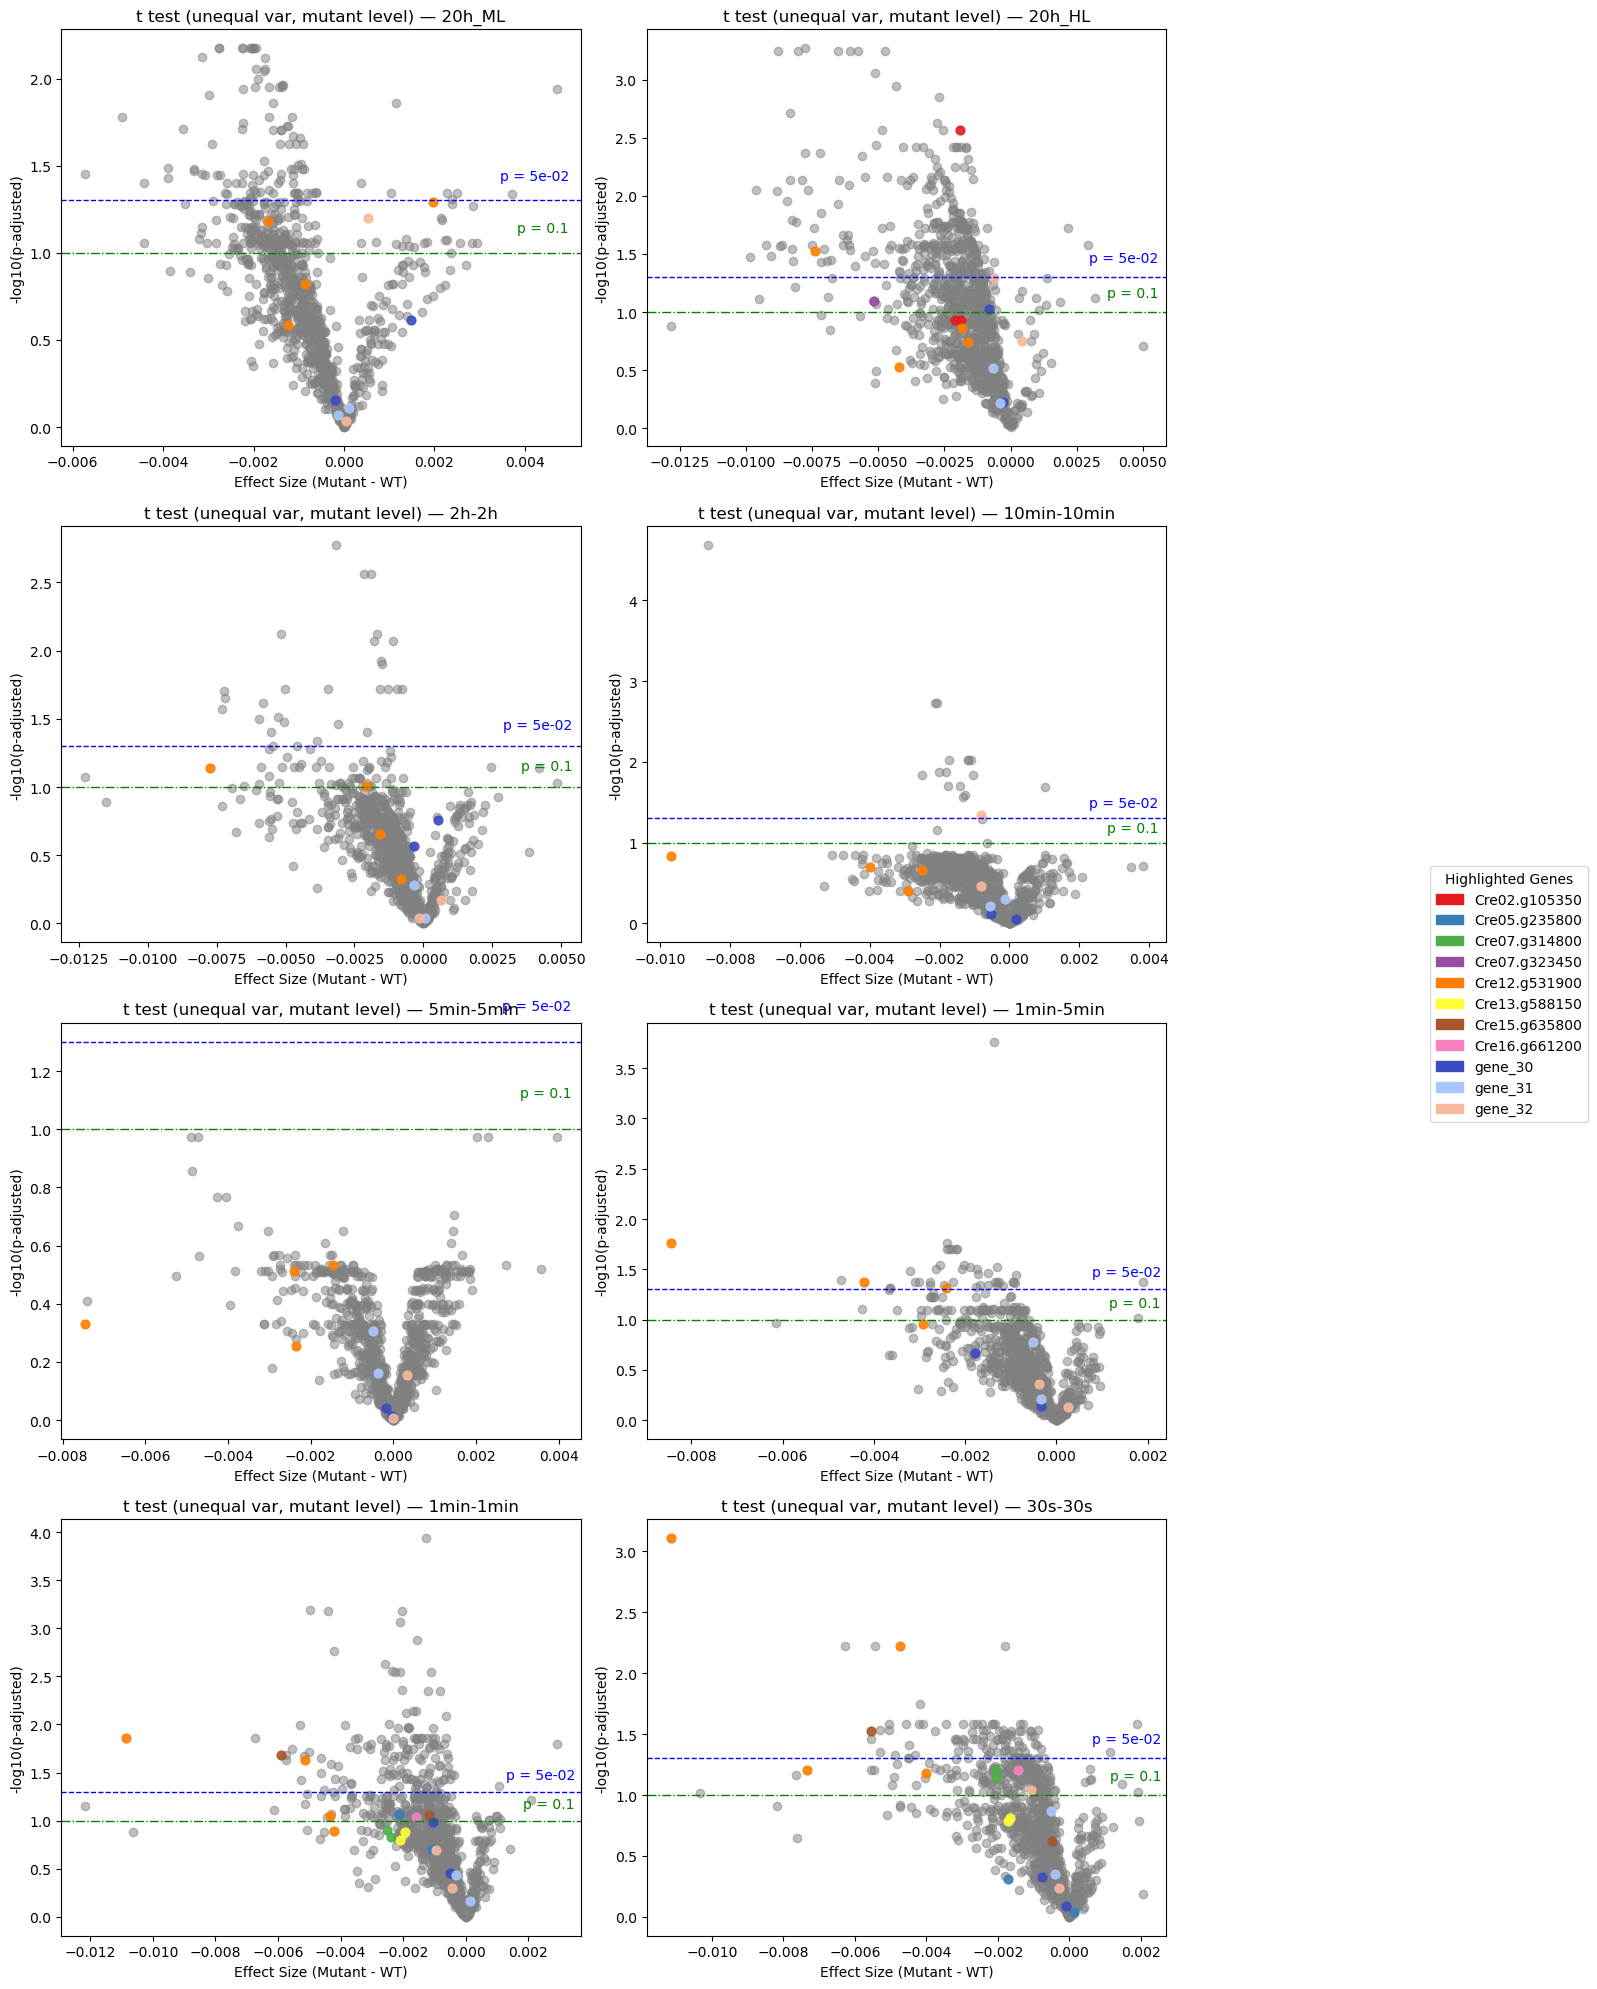

In [71]:
plot_volcano_per_light_regime2(
    ttest_results_all,
    p_thresh=0.05,
    regimes_order=['20h_ML', '20h_HL', '2h-2h', '10min-10min', '5min-5min', '1min-5min', '1min-1min', '30s-30s'],
    title_prefix='t test (unequal var, mutant level)'
)